# Xây dựng mô hình chú thích hình ảnh image captioning ngôn ngữ tiếng anh

### a) Tải và trực quan hóa dữ liệu:

Tải tập dữ liệu ảnh tại link:  [https://www.kaggle.com/datasets/adityajn105/flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) và tập caption tiếng Việt tại link: [https://www.kaggle.com/datasets/trungit/flickr8k-vi-caps/code](https://www.kaggle.com/datasets/trungit/flickr8k-vi-caps/code) 

Hiển thị một số ảnh mẫu kèm caption tiếng Anh và tiếng Việt, kiểm tra phân phối độ dài caption, phân chia dữ liệu thành tập huấn luyện, kiểm thử và kiểm định.

In [1]:
import os, random, string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from underthesea import word_tokenize

SEED = 2025
random.seed(SEED); np.random.seed(SEED)

ROOT_DIR = "/home/bbsw/truong/thuchang"
DATA_IMG_DIR = os.path.join(ROOT_DIR, "adityajn105_flickr8k/Images")
CAPTION_FILE = os.path.join(ROOT_DIR, "adityajn105_flickr8k/captions.txt")

SAVE_DIR = os.path.join(ROOT_DIR, "model_en/data/processed")
os.makedirs(SAVE_DIR, exist_ok=True)

print("Data image dir:", DATA_IMG_DIR)
print("Captions file:", CAPTION_FILE)
print("Save processed to:", SAVE_DIR)

Data image dir: /home/bbsw/truong/thuchang/adityajn105_flickr8k/Images
Captions file: /home/bbsw/truong/thuchang/adityajn105_flickr8k/captions.txt
Save processed to: /home/bbsw/truong/thuchang/model_en/data/processed


In [2]:
def load_flickr8k_captions_en(caption_file):
    df = pd.read_csv(caption_file)
    df["caption"] = df["caption"].astype(str).str.strip().str.lower()
    df["image"] = df["image"].astype(str).str.strip()
    return df

df = load_flickr8k_captions_en(CAPTION_FILE)
print("Loaded captions:", len(df))

Loaded captions: 40455


In [3]:
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...

In [4]:
from sklearn.model_selection import train_test_split

all_images = df["image"].unique().tolist()
print(f"Tổng số ảnh khác nhau: {len(all_images)}")

Tổng số ảnh khác nhau: 8091


In [5]:
# Chia dữ liệu: 80% train, 10% val, 10% test
train_imgs, temp_imgs = train_test_split(all_images, test_size=0.2, random_state=SEED)
val_imgs, test_imgs   = train_test_split(temp_imgs, test_size=0.5, random_state=SEED)

print(f"Số lượng ảnh:")
print(f"   Train: {len(train_imgs)}")
print(f"   Val:   {len(val_imgs)}")
print(f"   Test:  {len(test_imgs)}")

Số lượng ảnh:
   Train: 6472
   Val:   809
   Test:  810


In [6]:
def clean_english_text(text):
    text = text.lower()
    text = text.replace(".", " ")
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = ' '.join(text.split())
    return word_tokenize(text, format="text")

In [7]:
def process_captions_en(df_subset):
    records = []
    for _, row in df_subset.iterrows():
        cleaned = clean_english_text(row["caption"])
        records.append({
            "image": row["image"],
            "caption": f"startseq {cleaned} endseq"
        })
    return pd.DataFrame(records)

In [8]:
train_df = df[df["image"].isin(train_imgs)]
val_df   = df[df["image"].isin(val_imgs)]
test_df  = df[df["image"].isin(test_imgs)]
train_df = process_captions_en(train_df)
val_df   = process_captions_en(val_df)
test_df  = process_captions_en(test_df)
train_df.to_csv(os.path.join(SAVE_DIR, "train.csv"), index=False)
val_df.to_csv(os.path.join(SAVE_DIR, "val.csv"), index=False)
test_df.to_csv(os.path.join(SAVE_DIR, "test.csv"), index=False)

In [9]:
print(f"\nKết quả chia dữ liệu:")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"Đã lưu CSV vào: {SAVE_DIR}")


Kết quả chia dữ liệu:
Train: 32360 | Val: 4045 | Test: 4050
Đã lưu CSV vào: /home/bbsw/truong/thuchang/model_en/data/processed


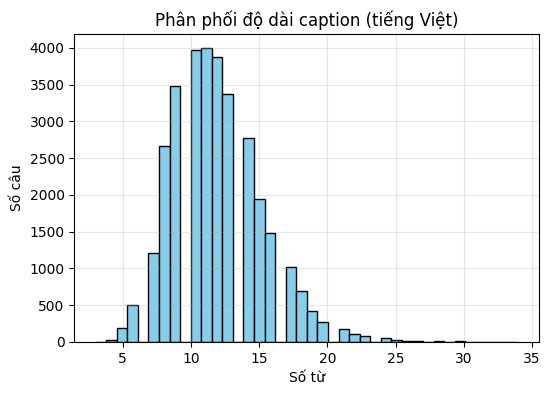

Số từ tối đa trong caption: 34
Số từ tối thiểu trong caption: 3
Số từ trung bình trong caption: 11.89


In [10]:
# PHÂN PHỐI ĐỘ DÀI CAPTION
lengths = [len(c.split()) for c in train_df["caption"]]
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=40, color='skyblue', edgecolor='black')
plt.title("Phân phối độ dài caption (tiếng Việt)")
plt.xlabel("Số từ"); plt.ylabel("Số câu")
plt.grid(alpha=0.3)
plt.show()

MAX_LEN = max(lengths)
print("Số từ tối đa trong caption:", MAX_LEN)
MiN_LEN = min(lengths)
print("Số từ tối thiểu trong caption:", MiN_LEN)
MEAN_LEN = sum(lengths) / len(lengths)
print("Số từ trung bình trong caption:", round(MEAN_LEN, 2))

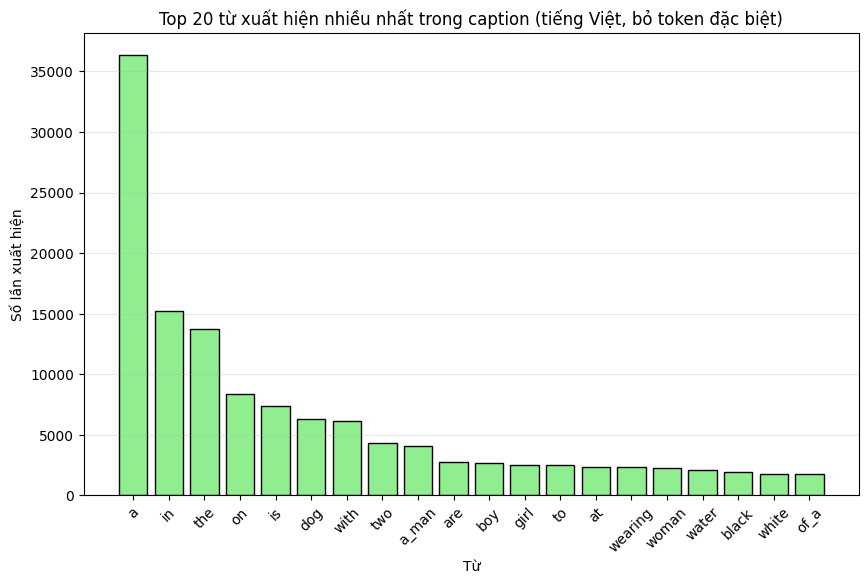

In [11]:
from collections import Counter

# Gộp caption thành danh sách từ
all_captions = ' '.join(train_df['caption']).split()

# Loại bỏ token đặc biệt
special_tokens = {"startseq", "endseq"}
filtered_words = [w for w in all_captions if w not in special_tokens]

word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(20)

words, counts = zip(*most_common_words)
plt.figure(figsize=(10,6))
plt.bar(words, counts, color='lightgreen', edgecolor='black')
plt.title("Top 20 từ xuất hiện nhiều nhất trong caption (tiếng Việt, bỏ token đặc biệt)")
plt.xlabel("Từ"); plt.ylabel("Số lần xuất hiện")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

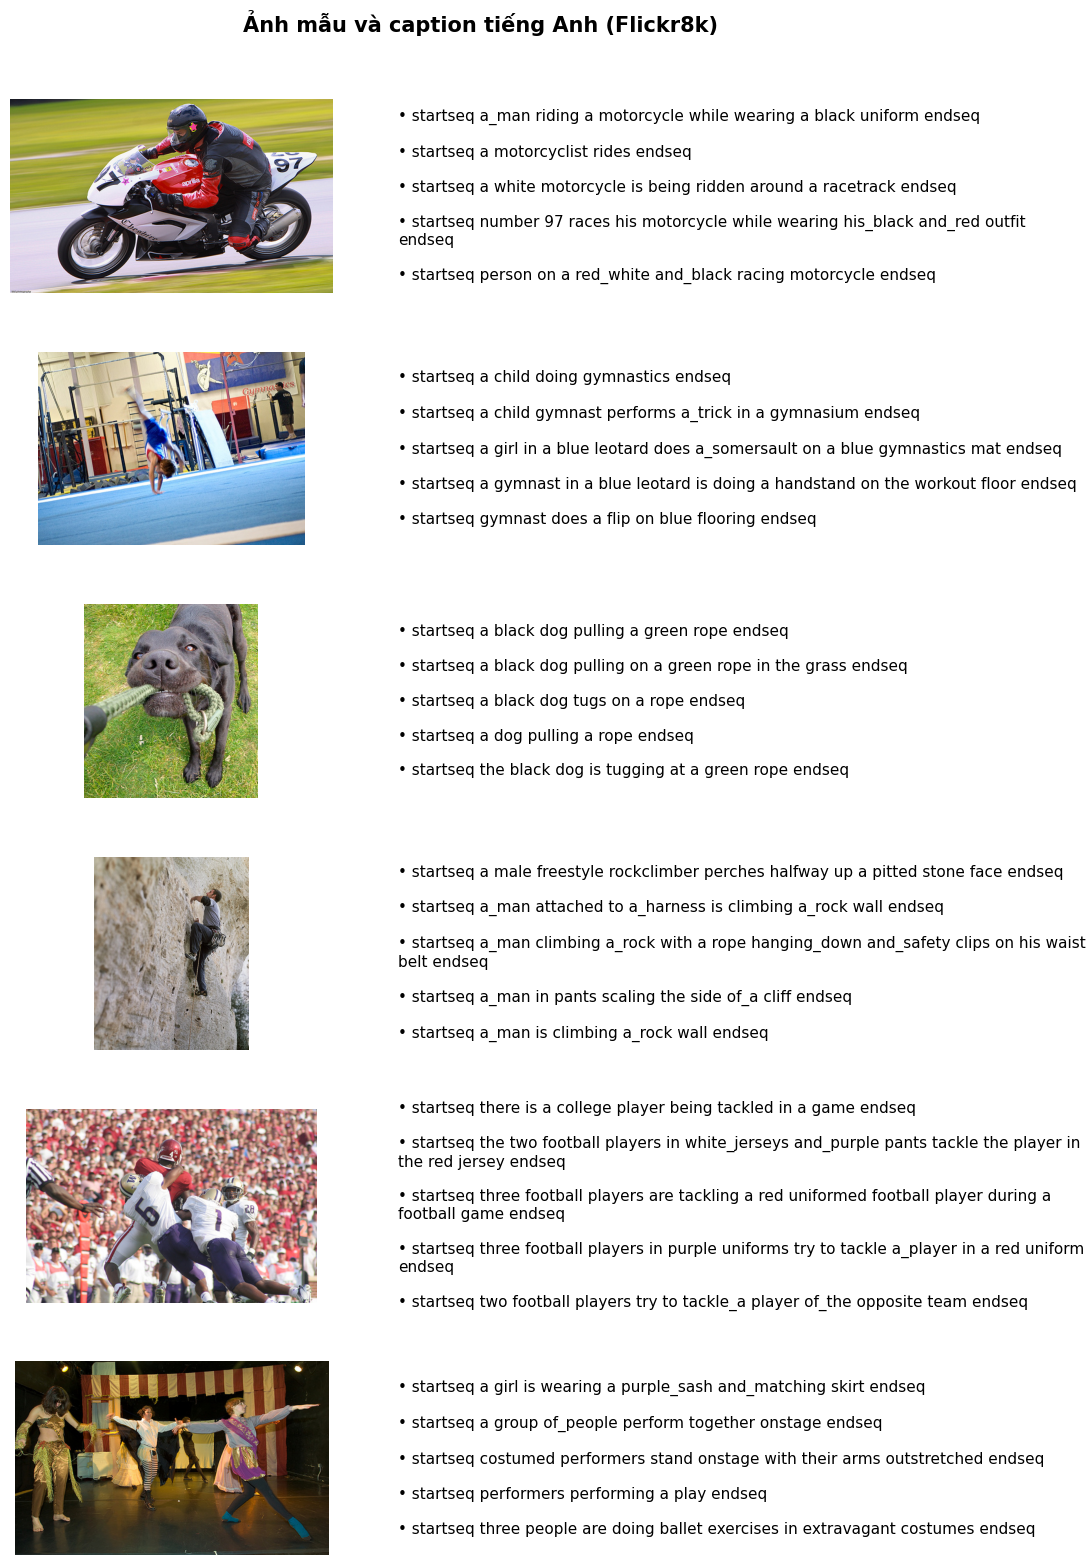

In [12]:
# import matplotlib.pyplot as plt
# import random, os
# from PIL import Image

# Lấy 6 ảnh ngẫu nhiên từ train_df
sample_imgs = random.sample(train_df["image"].unique().tolist(), 6)

plt.figure(figsize=(12, 16))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(DATA_IMG_DIR, img_name)
    if not os.path.exists(img_path):
        print(f"⚠️ Ảnh không tồn tại: {img_path}")
        continue

    # Lấy 3–5 caption đầu (tuỳ dataset)
    captions = train_df[train_df["image"] == img_name]["caption"].tolist()[:5]
    if len(captions) == 0:
        print(f"⚠️ Không có caption cho ảnh {img_name}")
        continue

    # Cột trái: ảnh
    plt.subplot(len(sample_imgs), 2, 2*i + 1)
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.axis("off")

    # Cột phải: caption
    plt.subplot(len(sample_imgs), 2, 2*i + 2)
    text_block = "\n\n".join([f"• {cap}" for cap in captions])
    plt.text(
        0, 0.5, text_block,
        fontsize=11, va="center", wrap=True,
        family="DejaVu Sans"
    )
    plt.axis("off")

plt.suptitle("Ảnh mẫu và caption tiếng Anh (Flickr8k)", fontsize=15, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### b) Xây dựng mô hình CNN–RNN cơ bản:

Thiết kế mạng sử dụng một backbone CNN (ví dụ VGG16, ResNet, InceptionV3,...) để trích xuất đặc trưng ảnh, kết hợp với RNN (LSTM hoặc GRU) để sinh chuỗi caption. 

Sử dụng Embedding layer cho caption và Softmax để dự đoán từ tiếp theo.

In [3]:
import os, torch, random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
from collections import Counter
torch.cuda.set_device(0)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

ROOT_DIR = "/home/bbsw/truong/thuchang/model_en"
DATA_IMG_DIR = "/home/bbsw/truong/thuchang/adityajn105_flickr8k/Images"
PROCESSED_DIR = os.path.join(ROOT_DIR, "data/processed")
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(PROCESSED_DIR, "train.csv"))
val_df   = pd.read_csv(os.path.join(PROCESSED_DIR, "val.csv"))
test_df  = pd.read_csv(os.path.join(PROCESSED_DIR, "test.csv"))
print(f"Train: {len(train_df)} | Val: {len(val_df)}")

# Transform ảnh
img_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

Device: cuda:0
Train: 32360 | Val: 4045


Gán ID cho từng từ trong caption

Loại bỏ các từ ít phổ biến trong tập dữ liệu

Token được chuyển thành dánh sách chỉ số token 

PAD – padding (dùng khi căn chỉnh độ dài câu)

SOS – Start Of Sentence (bắt đầu câu)

EOS – End Of Sentence (kết thúc câu)

UNK – Unknown (từ không có trong từ điển)

In [15]:
import re, json
from tqdm import tqdm

class VocabularyEN:
    def __init__(self, freq_threshold=5):
        self.special_tokens = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]
        self.itos = {i: tok for i, tok in enumerate(self.special_tokens)}
        self.stoi = {tok: i for i, tok in enumerate(self.special_tokens)}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def tokenizer(self, text):
        text = text.lower()
        text = text.replace(".", " ")
        text = re.sub(r"[^a-z\s]", "", text)
        return text.split()

    def build_vocab(self, sentences):
        freqs = Counter()
        for s in tqdm(sentences, desc="🔤 Building English vocab"):
            for w in self.tokenizer(s):
                freqs[w] += 1
        sorted_freqs = dict(sorted(freqs.items(), key=lambda x: -x[1]))
        with open(os.path.join(SAVE_DIR, "vocab_en.json"), "w", encoding="utf-8") as f:
            json.dump(sorted_freqs, f, ensure_ascii=False, indent=2)
        print(f"Đã lưu thống kê tần suất từ vào: vocab_en.json")

        for w, f in sorted(freqs.items(), key=lambda x: -x[1]):
            if f >= self.freq_threshold:
                idx = len(self.itos)
                self.itos[idx] = w
                self.stoi[w] = idx
        with open(os.path.join(SAVE_DIR, "itos.json"), "w", encoding="utf-8") as f:
            json.dump(self.itos, f, ensure_ascii=False, indent=2)
        
        with open(os.path.join(SAVE_DIR, "stoi.json"), "w", encoding="utf-8") as f:
            json.dump(self.stoi, f, ensure_ascii=False, indent=2)
        print(f"✅ Vocabulary built: {len(self)} words (freq ≥ {self.freq_threshold})")

    def numericalize(self, text):
        tokens = self.tokenizer(text)
        ids = [self.stoi.get(w, self.stoi["<UNK>"]) for w in tokens]
        return [self.stoi["<SOS>"]] + ids + [self.stoi["<EOS>"]]

In [16]:
import pickle
vocab_en = VocabularyEN(freq_threshold=3)
vocab_en.build_vocab(train_df["caption"].tolist())

with open(os.path.join(SAVE_DIR, "vocab_en.pkl"), "wb") as f:
    pickle.dump(vocab_en, f)

🔤 Building English vocab: 100%|██████████| 32360/32360 [00:00<00:00, 434188.24it/s]

Đã lưu thống kê tần suất từ vào: vocab_en.json
✅ Vocabulary built: 4512 words (freq ≥ 3)


In [18]:
with open(os.path.join(SAVE_DIR, "vocab_en.pkl"), "rb") as f:
    vocab_en = pickle.load(f)
PAD_IDX = vocab_en.stoi["<PAD>"]
SOS_IDX = vocab_en.stoi["<SOS>"]
EOS_IDX = vocab_en.stoi["<EOS>"]
UNK_IDX = vocab_en.stoi["<UNK>"]
VOCAB_SIZE = len(vocab_en)
print(f"Loaded vocab: {VOCAB_SIZE} words")

Loaded vocab: 4512 words


In [19]:
# !pip install gensim
from gensim.models.fasttext import load_facebook_model

fasttext_path = "/home/bbsw/truong/thuchang/model_en/data/fasttestfb/cc.en.300.bin"
ft_model = load_facebook_model(fasttext_path)

print("FastText loaded. Vector size:", ft_model.wv.vector_size)
print(ft_model.wv["apple"][:10])

FastText loaded. Vector size: 300
[ 0.01440609 -0.01854071  0.07781687  0.09623271  0.06118292 -0.06858259
  0.1259418  -0.04569921 -0.07331041  0.05031696]


In [20]:
import numpy as np
import torch

VOCAB_SIZE = len(vocab_en)
EMBED_DIM = ft_model.wv.vector_size  # 300

# Tạo ma trận embedding
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))

found, missing = 0, 0

for word, idx in vocab_en.stoi.items():
    if word in ft_model.wv:
        embedding_matrix[idx] = ft_model.wv[word]
        found += 1
    else:
        # Nếu từ không có trong FastText → khởi tạo ngẫu nhiên
        # embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMBED_DIM,))
        missing += 1

print(f"✅ FastText loaded for {found}/{VOCAB_SIZE} words ({100*found/VOCAB_SIZE:.2f}%)")
print(f"❌ Missing words: {missing}/{VOCAB_SIZE}")


✅ FastText loaded for 4512/4512 words (100.00%)
❌ Missing words: 0/4512


In [21]:
class FlickrDataset(Dataset):
    def __init__(self, df, root, vocab):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.vocab = vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root, row["image"])
        img = Image.open(img_path).convert("RGB")
        img = img_tfms(img)
        cap = torch.tensor(self.vocab.numericalize(row["caption"]), dtype=torch.long)
        return img, cap

def pad_collate(batch):
    imgs, caps = zip(*batch)
    imgs = torch.stack(imgs)   # (batch_size, 3, 224, 224)
    lengths = [len(c) for c in caps]
    T = max(lengths)
    caps_pad = torch.full((len(caps), T), PAD_IDX, dtype=torch.long)
    for i, c in enumerate(caps):
        caps_pad[i, :len(c)] = c
    return imgs, caps_pad, torch.tensor(lengths)

train_loader = DataLoader(FlickrDataset(train_df, DATA_IMG_DIR, vocab_en),
                          batch_size=32, shuffle=True, collate_fn=pad_collate, num_workers=4)
val_loader   = DataLoader(FlickrDataset(val_df, DATA_IMG_DIR, vocab_en),
                          batch_size=32, shuffle=False, collate_fn=pad_collate, num_workers=4)
print("DataLoader ready.")

DataLoader ready.


Ảnh RGB (3x224x224) - ResNet50 - Feature map (2048x7x7) - giảm kênh Feature map (512x7x7) - Reshape (B, N=49, H=512)


mỗi ảnh có 49 vùng mỗi vùng ứng với một vector 512

In [30]:
# CNN ENCODER (ResNet50 backbone → 512-dim feature)
class CNNEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        modules = list(base.children())[:-2]  # keep spatial map (not flatten)
        self.backbone = nn.Sequential(*modules)
        self.conv = nn.Conv2d(2048, embed_dim, kernel_size=1)  # reduce channels
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        with torch.no_grad():
            feats = self.backbone(x)           # (B, 2048, 7, 7)
        feats = self.dropout(F.relu(self.conv(feats)))  # (B, 512, 7, 7)
        B, C, H, W = feats.shape
        feats = feats.view(B, C, -1).permute(0, 2, 1)   # (B, 49, 512)
        return feats


W_v: feature toàn cục

W_h: hidden trang thái model

v so sánh vùng

CNN chia thành 7×7 = 49 vùng, mỗi vùng là 1 vector dài 512

so sánh feature với hidden tính độ phù hợp qua tanh chuyển thành xác cuất chú ý attn 

In [31]:
# ATTENTION 
class Attention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.W_v = nn.Linear(dim, dim)   
        self.W_h = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, 1)

    def forward(self, features, hidden):
        """
        features: (B, N, H) — visual features
        hidden:   (B, H) — last hidden state from LSTM
        """
        hidden = hidden.unsqueeze(1).expand_as(features)
        energy = torch.tanh(self.W_v(features) + self.W_h(hidden))  # (B, N, H)
        attn = F.softmax(self.v(energy), dim=1)  # (B, N, 1)
        context = (attn * features).sum(1)       # (B, H)
        return context, attn

ảnh - attention - lstm - dự đoán từ tiếp theo

emd chuyển tù id -> vector

attemtion nhìn vào vùng ảnh 

lstm ghi nhớ ngữ cảnh và dự đoán từ tiếp theo

fc chuyển hidden thành xác suất t


In [36]:
# DECODER (LSTM + Attention)
class RNNDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, hidden_dim=512, pad_idx=0, embedding_matrix=None):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        if embedding_matrix is not None:
            self.embed.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.lstm = nn.LSTMCell(embed_dim + hidden_dim, hidden_dim)
        self.attn = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.init_h = nn.Linear(hidden_dim, hidden_dim)
        self.init_c = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3) 
    def forward(self, features, seqs, lengths):
        B, N, D = features.size()
        T = seqs.size(1) - 1

        embeddings = self.embed(seqs[:, :-1])  # (B, T, embed_dim)
        h = torch.zeros(B, D, device=features.device)
        c = torch.zeros(B, D, device=features.device)

        outputs = []
        for t in range(T):
            context, _ = self.attn(features, h)
            lstm_input = torch.cat([embeddings[:, t, :], context], dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            h = self.dropout(h) 
            out = self.fc(h)
            outputs.append(out.unsqueeze(1))
        return torch.cat(outputs, dim=1)  # (B, T, vocab_size)

Ảnh → CNN Encoder → Đặc trưng ảnh

LSTM Decoder (với Attention) → Sinh caption từng từ

In [37]:
# FINAL CAPTION MODEL
class CaptionModel(nn.Module):
    def __init__(self, vocab_size, pad_idx):
        super().__init__()
        self.encoder = CNNEncoder(embed_dim=300)
        self.decoder = RNNDecoder(vocab_size, embed_dim=300, hidden_dim=300, pad_idx=pad_idx, embedding_matrix=embedding_matrix)

    def forward(self, imgs, seqs, lengths):
        feats = self.encoder(imgs)
        return self.decoder(feats, seqs, lengths)

In [ ]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

def seq_loss(logits, targets, pad_idx, smoothing=0.1):
    n_class = logits.size(-1)
    logits = logits.view(-1, n_class)
    targets = targets[:,1:].reshape(-1)
    true_dist = torch.zeros_like(logits)
    true_dist.fill_(smoothing / (n_class - 1))
    mask = targets != pad_idx
    true_dist[mask, targets[mask]] = 1.0 - smoothing
    loss = -(true_dist * F.log_softmax(logits, dim=-1)).sum(dim=1)
    return loss.mean()  

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    pbar = tqdm(loader, desc="Training", leave=False)

    for imgs, seqs, lens in pbar:
        imgs, seqs, lens = imgs.to(DEVICE), seqs.to(DEVICE), lens.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)

        # ⚡ Mixed Precision Training
        with autocast(dtype=torch.float16):
            logits = model(imgs, seqs, lens)
            loss = seq_loss(logits, seqs, PAD_IDX)

        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix({"batch_loss": f"{loss.item():.3f}"})

    return total_loss / len(loader)

/tmp/ipykernel_1563603/3542423978.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


🔒 Frozen ResNet backbone for first 5 epochs
✅ Model initialized on cuda:0
Vocab size: 4512
Training for 20 epochs...


========== Epoch 1/20 ==========


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/tmp/ipykernel_1563603/3542423978.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


[01] Train 3.906 | Val 3.556
✅ Saved best model!

========== Epoch 2/20 ==========


[02] Train 3.492 | Val 3.333
✅ Saved best model!

========== Epoch 3/20 ==========


[03] Train 3.330 | Val 3.253
✅ Saved best model!

========== Epoch 4/20 ==========


[04] Train 3.253 | Val 3.185
✅ Saved best model!

========== Epoch 5/20 ==========


[05] Train 3.213 | Val 3.152
✅ Saved best model!

========== Epoch 6/20 ==========
🔓 Unfrozen ResNet backbone from epoch 6


[06] Train 3.176 | Val 3.117
✅ Saved best model!

========== Epoch 7/20 ==========


[07] Train 3.144 | Val 3.099
✅ Saved best model!

========== Epoch 8/20 ==========


[08] Train 3.135 | Val 3.081
✅ Saved best model!

========== Epoch 9/20 ==========


[09] Train 3.114 | Val 3.072
✅ Saved best model!

========== Epoch 10/20 ==========


[10] Train 3.104 | Val 3.061
✅ Saved best model!

========== Epoch 11/20 ==========


[11] Train 3.092 | Val 3.045
✅ Saved best model!

========== Epoch 12/20 ==========


[12] Train 3.069 | Val 3.028
✅ Saved best model!

========== Epoch 13/20 ==========


[13] Train 3.059 | Val 3.020
✅ Saved best model!

========== Epoch 14/20 ==========


[14] Train 3.045 | Val 3.013
✅ Saved best model!

========== Epoch 15/20 ==========


[15] Train 3.045 | Val 3.005
✅ Saved best model!

========== Epoch 16/20 ==========


[16] Train 3.040 | Val 2.998
✅ Saved best model!

========== Epoch 17/20 ==========


[17] Train 3.031 | Val 2.992
✅ Saved best model!

========== Epoch 18/20 ==========


[18] Train 3.021 | Val 2.985
✅ Saved best model!

========== Epoch 19/20 ==========


[19] Train 3.017 | Val 2.978
✅ Saved best model!

========== Epoch 20/20 ==========


[20] Train 3.009 | Val 2.972
✅ Saved best model!


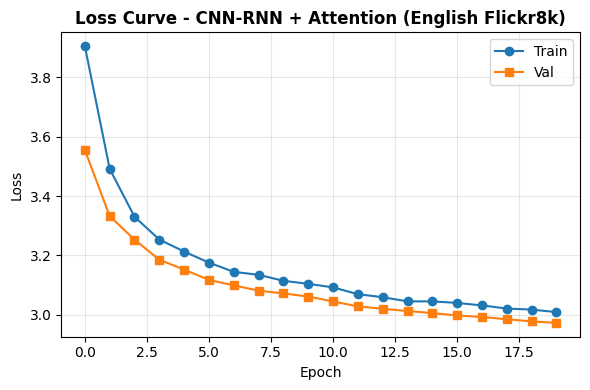

In [39]:
@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    pbar = tqdm(loader, desc="Validating", leave=False)

    for imgs, seqs, lens in pbar:
        imgs, seqs, lens = imgs.to(DEVICE), seqs.to(DEVICE), lens.to(DEVICE)
        logits = model(imgs, seqs, lens)
        loss = seq_loss(logits, seqs, PAD_IDX)
        total_loss += loss.item()
        pbar.set_postfix({"val_loss": f"{loss.item():.3f}"})

    return total_loss / len(loader)

EPOCHS = 20
LR = 1e-4
model = CaptionModel(VOCAB_SIZE, PAD_IDX).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)
for p in model.encoder.backbone.parameters():
    p.requires_grad = False
print("🔒 Frozen ResNet backbone for first 5 epochs")

best_val = float("inf")
train_loss_hist, val_loss_hist = [], []

print(f"✅ Model initialized on {DEVICE}")
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Training for {EPOCHS} epochs...\n")

for ep in range(1, EPOCHS + 1):
    print(f"\n========== Epoch {ep}/{EPOCHS} ==========")
    if ep == 6:
        for p in model.encoder.backbone.parameters():
            p.requires_grad = True
        print("🔓 Unfrozen ResNet backbone from epoch 6")
    tr_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss = eval_one_epoch(model, val_loader)

    train_loss_hist.append(tr_loss)
    val_loss_hist.append(val_loss)
    scheduler.step(val_loss)

    print(f"[{ep:02d}] Train {tr_loss:.3f} | Val {val_loss:.3f}")

    # if val_loss < best_val - 1e-3:
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "cnn_rnn_attn_best.pt"))
        print("✅ Saved best model!")

plt.figure(figsize=(6, 4))
plt.plot(train_loss_hist, label="Train", marker="o")
plt.plot(val_loss_hist, label="Val", marker="s")
plt.title("Loss Curve - CNN-RNN + Attention (English Flickr8k)", fontsize=12, weight="bold")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### c) Huấn luyện và đánh giá mô hình CNN–RNN

Huấn luyện mô hình trên tập huấn luyện, đánh giá trên tập kiểm thử bằng các chỉ số **BLEU**, **METEOR** hoặc **ROUGE**. 

Hiển thị một số ảnh kèm caption dự đoán và caption thực tế để so sánh.

In [40]:
import textwrap
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import sacrebleu
import os, torch, random

model_path = os.path.join(CHECKPOINT_DIR, "cnn_rnn_attn_best.pt")
cnn_rnn = CaptionModel(VOCAB_SIZE, PAD_IDX).to(DEVICE)
cnn_rnn.load_state_dict(torch.load(model_path, map_location=DEVICE))
print(f"Loaded model from {model_path}")
cnn_rnn.eval()

Loaded model from /home/bbsw/truong/thuchang/model_en/checkpoints/cnn_rnn_attn_best.pt


CaptionModel(
  (encoder): CNNEncoder(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

In [41]:
# @torch.no_grad()
# def generate_caption(model, img_path, vocab, max_len=40):
#     model.eval()

#     # 1 Tiền xử lý ảnh
#     img = Image.open(img_path).convert("RGB")
#     img_tensor = img_tfms(img).unsqueeze(0).to(DEVICE)  # [1, 3, 224, 224]
#     feats = model.enc(img_tensor)  # [1, embed_dim]

#     # 2️ Khởi tạo chuỗi đầu vào với token <SOS>
#     seq = [vocab.stoi["<SOS>"]]

#     # 3️ Sinh dần từng token mới
#     for _ in range(max_len):
#         inp = torch.tensor(seq, dtype=torch.long, device=DEVICE).unsqueeze(0)  # [1, L]
#         lengths = torch.tensor([len(seq)], device=DEVICE)
#         logits = model.dec(feats, inp, lengths)  # [1, L, vocab_size]
#         next_id = int(logits[0, -1].argmax(-1))  # Lấy token xác suất cao nhất

#         seq.append(next_id)
#         if next_id == vocab.stoi["<EOS>"]:
#             break

#     # 4️ Giải mã chuỗi ID → caption
#     caption = " ".join(vocab.itos[i] for i in seq if i not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]])
#     return caption


In [42]:
@torch.no_grad()
def generate_caption(model, img_path, vocab, max_len=40):
    model.eval()
    # 1️ Tiền xử lý ảnh
    img = Image.open(img_path).convert("RGB")
    img_tensor = img_tfms(img).unsqueeze(0).to(DEVICE)  # (1, 3, 224, 224)

    # 2️ Lấy đặc trưng ảnh từ encoder
    features = model.encoder(img_tensor)  # (1, 49, 512)

    # 3️ Khởi tạo hidden, cell state
    B, N, D = features.size()
    h = torch.zeros(B, D, device=DEVICE)
    c = torch.zeros(B, D, device=DEVICE)

    # 4️ Chuỗi khởi đầu với token <SOS>
    seq = [vocab.stoi["<SOS>"]]

    for _ in range(max_len):
        inp = torch.tensor([seq[-1]], dtype=torch.long, device=DEVICE).unsqueeze(0)  # (1,1)
        emb = model.decoder.embed(inp).squeeze(1)  # (1, embed_dim)

        # Attention
        context, _ = model.decoder.attn(features, h)
        lstm_input = torch.cat([emb, context], dim=1)
        h, c = model.decoder.lstm(lstm_input, (h, c))
        out = model.decoder.fc(h)
        next_id = int(out.argmax(-1))

        seq.append(next_id)
        if next_id == vocab.stoi["<EOS>"]:
            break

    # 5️ Giải mã chuỗi ID → caption text
    caption = " ".join(
        vocab.itos[i]
        for i in seq
        if i not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]
    )
    return caption

/tmp/ipykernel_1563603/2204690783.py:32: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


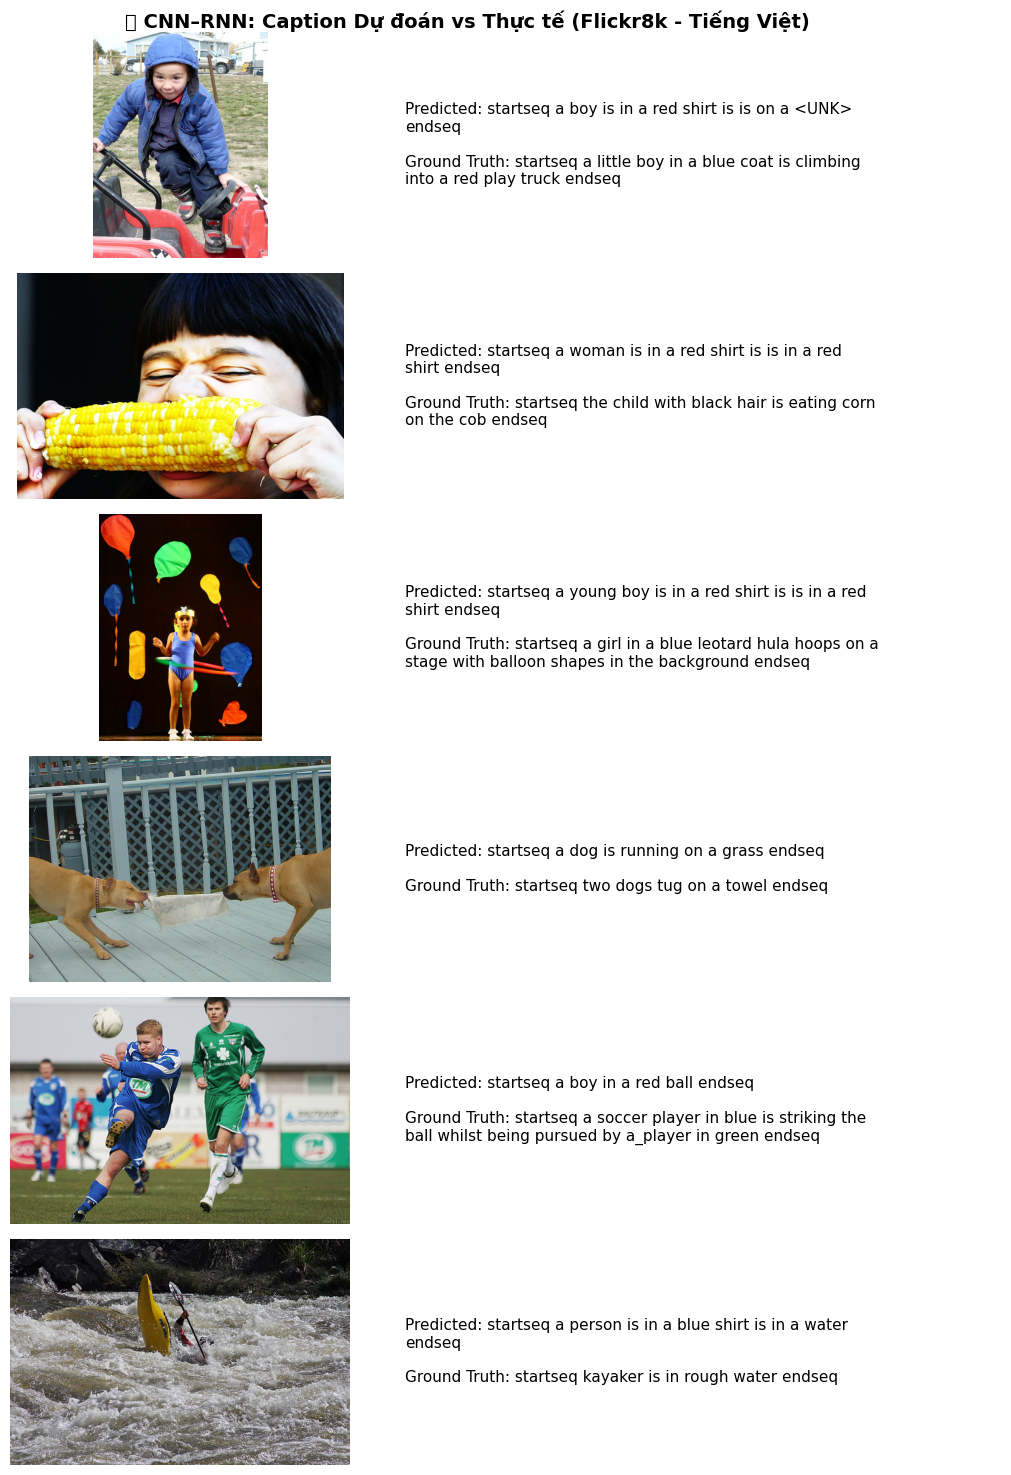

In [48]:
sample_imgs = random.sample(list(val_df["image"].unique()), 6)

plt.figure(figsize=(12, 15))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(DATA_IMG_DIR, img_name)
    if not os.path.exists(img_path):
        continue

    # Caption dự đoán
    pred = generate_caption(cnn_rnn, img_path, vocab_en)

    # Caption thật (random từ train hoặc val)
    if img_name in train_df["image"].values:
        gt_list = train_df[train_df["image"] == img_name]["caption"].tolist()
    else:
        gt_list = val_df[val_df["image"] == img_name]["caption"].tolist()
    gt = random.choice(gt_list)

    # Ảnh ở cột trái
    plt.subplot(len(sample_imgs), 2, 2*i + 1)
    plt.imshow(Image.open(img_path).convert("RGB"))
    plt.axis("off")

    # Caption ở cột phải
    text_pred = "\n".join(textwrap.wrap(f"Predicted:\n{pred}", 65))
    text_gt   = "\n".join(textwrap.wrap(f"Ground Truth:\n{gt}", 65))
    plt.subplot(len(sample_imgs), 2, 2*i + 2)
    plt.text(0, 0.5, f"{text_pred}\n\n{text_gt}", fontsize=11, va='center', wrap=True)
    plt.axis("off")

plt.suptitle("🖼️ CNN–RNN: Caption Dự đoán vs Thực tế (Flickr8k - Tiếng Việt)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [49]:
@torch.no_grad()
def evaluate_model(model, df, max_samples=300):
    refs_all_tok, hyps_all_tok = [], []
    hyps_str = []

    sample_imgs = random.sample(list(df["image"].unique()), min(max_samples, len(df["image"].unique())))

    for img_id in sample_imgs:
        img_path = os.path.join(DATA_IMG_DIR, img_id)
        hyp_raw = generate_caption(model, img_path, vocab_en)
        hyp_tok = hyp_raw.split()
        refs_tok = [cap.split() for cap in df[df["image"] == img_id]["caption"].tolist()]
        refs_all_tok.append(refs_tok)
        hyps_all_tok.append(hyp_tok)
        hyps_str.append(" ".join(hyp_tok))

    # BLEU
    bleu1 = corpus_bleu(refs_all_tok, hyps_all_tok, weights=(1,0,0,0))
    bleu2 = corpus_bleu(refs_all_tok, hyps_all_tok, weights=(0.5,0.5,0,0))
    bleu3 = corpus_bleu(refs_all_tok, hyps_all_tok, weights=(1/3,1/3,1/3,0))
    bleu4 = corpus_bleu(refs_all_tok, hyps_all_tok, weights=(0.25,0.25,0.25,0.25))

    # METEOR, ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
    meteors, r1, rL = [], [], []
    for refs_tok, hyp_str in zip(refs_all_tok, hyps_str):
        meteors.append(max(meteor_score(refs_tok, hyp_str.split()), 0.0))
        refs_str = [" ".join(r) for r in refs_tok]
        s_best = max([scorer.score(r, hyp_str) for r in refs_str], key=lambda s: s['rouge1'].fmeasure)
        r1.append(s_best['rouge1'].fmeasure)
        rL.append(s_best['rougeL'].fmeasure)

    # chrF++
    # refs_str_nested = [[ " ".join(r) for r in refs_tok ] for refs_tok in refs_all_tok]
    # chrf = sacrebleu.corpus_chrf(hyps_str, refs_str_nested).score

    return {
        "BLEU-1": float(bleu1),
        "BLEU-2": float(bleu2),
        "BLEU-3": float(bleu3),
        "BLEU-4": float(bleu4),
        "METEOR": float(np.mean(meteors)),
        "ROUGE-1": float(np.mean(r1)),
        "ROUGE-L": float(np.mean(rL)),
        # "chrF++": float(chrf)
    }

metrics_cnn = evaluate_model(cnn_rnn, val_df, max_samples=300)
print("Kết quả đánh giá CNN–RNN (tiếng ANh):")
for k,v in metrics_cnn.items():
    print(f"{k:10s}: {v:.4f}")

Kết quả đánh giá CNN–RNN (tiếng ANh):
BLEU-1    : 0.5886
BLEU-2    : 0.3756
BLEU-3    : 0.2244
BLEU-4    : 0.1353
METEOR    : 0.3654
ROUGE-1   : 0.5001
ROUGE-L   : 0.4822


In [ ]:

import heapq

@torch.no_grad()
def generate_caption_beam(model, img_path, vocab, beam_size=3, max_len=40):
    model.eval()

    img = Image.open(img_path).convert("RGB")
    img_tensor = img_tfms(img).unsqueeze(0).to(DEVICE)  # (1, 3, 224, 224)

    features = model.encoder(img_tensor)  # (1, 49, 512)
    B, N, D = features.size()

    # 3️⃣ Khởi tạo beam
    # Mỗi phần tử trong beam: (log_prob, seq, h, c)
    h = torch.zeros(B, D, device=DEVICE)
    c = torch.zeros(B, D, device=DEVICE)
    start_token = vocab.stoi["<SOS>"]

    beams = [(0.0, [start_token], h, c)]  # log_prob = 0 lúc đầu

    completed = []

    for _ in range(max_len):
        candidates = []
        for log_prob, seq, h, c in beams:
            # Nếu chuỗi đã kết thúc → giữ nguyên
            if seq[-1] == vocab.stoi["<EOS>"]:
                completed.append((log_prob, seq))
                continue

            inp = torch.tensor([seq[-1]], dtype=torch.long, device=DEVICE).unsqueeze(0)  # (1,1)
            emb = model.decoder.embed(inp).squeeze(1)  # (1, embed_dim)

            # Attention
            context, _ = model.decoder.attn(features, h)
            lstm_input = torch.cat([emb, context], dim=1)
            h_new, c_new = model.decoder.lstm(lstm_input, (h, c))
            out = model.decoder.fc(h_new)
            log_probs = torch.log_softmax(out, dim=-1).squeeze(0)

            # Chọn top-k token ứng viên
            topk_log_probs, topk_ids = torch.topk(log_probs, beam_size)

            for next_log_prob, next_id in zip(topk_log_probs, topk_ids):
                new_seq = seq + [int(next_id)]
                new_log_prob = log_prob + float(next_log_prob)
                candidates.append((new_log_prob, new_seq, h_new, c_new))

        # Nếu không còn ứng viên (tất cả đã kết thúc)
        if not candidates:
            break

        # Giữ lại beam_size chuỗi có log_prob cao nhất
        beams = sorted(candidates, key=lambda x: x[0], reverse=True)[:beam_size]

    # 5️⃣ Kết thúc: chọn chuỗi tốt nhất
    if not completed:
        completed = beams
    best_seq = max(completed, key=lambda x: x[0])[1]

    caption = " ".join(
        vocab.itos[i]
        for i in best_seq
        if i not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]
    )
    return caption


/tmp/ipykernel_1372732/1923922034.py:32: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


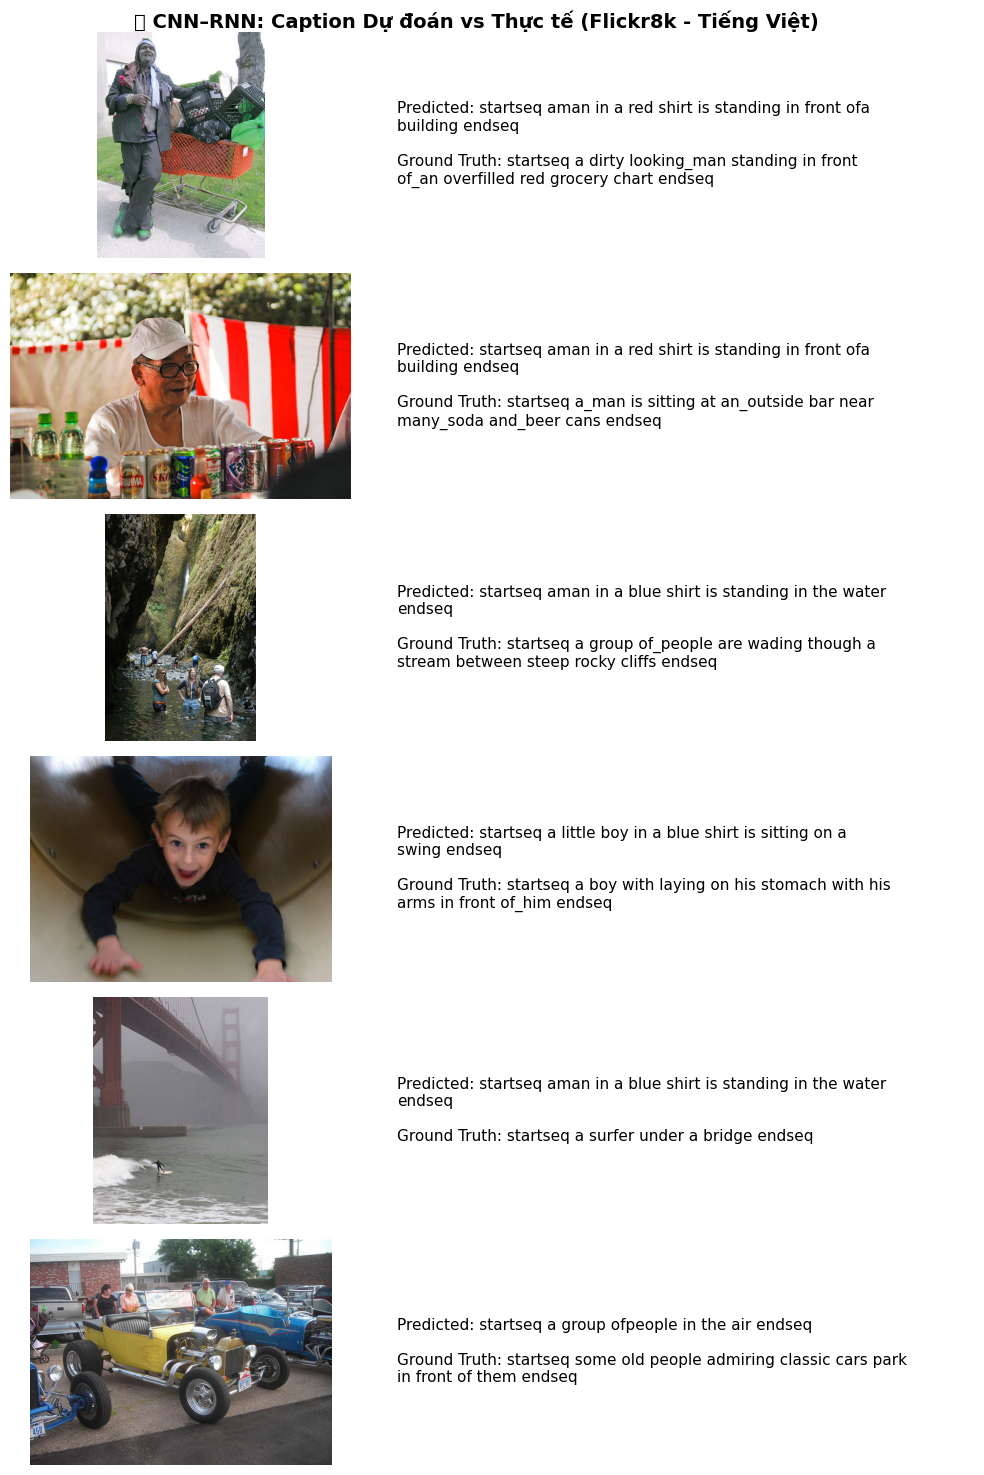

In [38]:
sample_imgs = random.sample(list(val_df["image"].unique()), 6)

plt.figure(figsize=(12, 15))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(DATA_IMG_DIR, img_name)
    if not os.path.exists(img_path):
        continue

    # Caption dự đoán
    pred = generate_caption_beam(cnn_rnn, img_path, vocab_en)

    # Caption thật (random từ train hoặc val)
    if img_name in train_df["image"].values:
        gt_list = train_df[train_df["image"] == img_name]["caption"].tolist()
    else:
        gt_list = val_df[val_df["image"] == img_name]["caption"].tolist()
    gt = random.choice(gt_list)

    # Ảnh ở cột trái
    plt.subplot(len(sample_imgs), 2, 2*i + 1)
    plt.imshow(Image.open(img_path).convert("RGB"))
    plt.axis("off")

    # Caption ở cột phải
    text_pred = "\n".join(textwrap.wrap(f"Predicted:\n{pred}", 65))
    text_gt   = "\n".join(textwrap.wrap(f"Ground Truth:\n{gt}", 65))
    plt.subplot(len(sample_imgs), 2, 2*i + 2)
    plt.text(0, 0.5, f"{text_pred}\n\n{text_gt}", fontsize=11, va='center', wrap=True)
    plt.axis("off")

plt.suptitle("🖼️ CNN–RNN: Caption Dự đoán vs Thực tế (Flickr8k - Tiếng Việt)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [ ]:
@torch.no_grad()
def evaluate_model(model, df, max_samples=300):
    refs_all_tok, hyps_all_tok = [], []
    hyps_str = []

    sample_imgs = random.sample(list(df["image"].unique()), min(max_samples, len(df["image"].unique())))

    for img_id in sample_imgs:
        img_path = os.path.join(DATA_IMG_DIR, img_id)
        hyp_raw = generate_caption_beam(model, img_path, vocab_en)
        hyp_tok = hyp_raw.split()
        refs_tok = [cap.split() for cap in df[df["image"] == img_id]["caption"].tolist()]
        refs_all_tok.append(refs_tok)
        hyps_all_tok.append(hyp_tok)
        hyps_str.append(" ".join(hyp_tok))

    # BLEU
    bleu1 = corpus_bleu(refs_all_tok, hyps_all_tok, weights=(1,0,0,0))
    bleu2 = corpus_bleu(refs_all_tok, hyps_all_tok, weights=(0.5,0.5,0,0))
    bleu3 = corpus_bleu(refs_all_tok, hyps_all_tok, weights=(1/3,1/3,1/3,0))
    bleu4 = corpus_bleu(refs_all_tok, hyps_all_tok, weights=(0.25,0.25,0.25,0.25))

    # METEOR, ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
    meteors, r1, rL = [], [], []
    for refs_tok, hyp_str in zip(refs_all_tok, hyps_str):
        meteors.append(max(meteor_score(refs_tok, hyp_str.split()), 0.0))
        refs_str = [" ".join(r) for r in refs_tok]
        s_best = max([scorer.score(r, hyp_str) for r in refs_str], key=lambda s: s['rouge1'].fmeasure)
        r1.append(s_best['rouge1'].fmeasure)
        rL.append(s_best['rougeL'].fmeasure)

    return {
        "BLEU-1": float(bleu1),
        "BLEU-2": float(bleu2),
        "BLEU-3": float(bleu3),
        "BLEU-4": float(bleu4),
        "METEOR": float(np.mean(meteors)),
        "ROUGE-1": float(np.mean(r1)),
        "ROUGE-L": float(np.mean(rL)),
    }

metrics_cnn = evaluate_model(cnn_rnn, val_df, max_samples=300)
print("Kết quả đánh giá CNN–RNN (tiếng ANh):")
for k,v in metrics_cnn.items():
    print(f"{k:10s}: {v:.4f}")

Kết quả đánh giá CNN–RNN (tiếng ANh):
BLEU-1    : 0.5979
BLEU-2    : 0.3813
BLEU-3    : 0.2374
BLEU-4    : 0.1511
METEOR    : 0.3949
ROUGE-1   : 0.5054
ROUGE-L   : 0.4642


### d) Tối ưu mô hình:** Thử nghiệm điều chỉnh siêu tham số như:

learning rate, batch size, số lớp RNN, số chiều embedding

Sử dụng kỹ thuật **Early Stopping** và **Learning Rate Scheduler** để cải thiện hiệu suất.

In [50]:
# TỐI ƯU HUẤN LUYỆN (EarlyStopping + Scheduler)
import time, json

LOG_DIR = os.path.join(ROOT_DIR, "logs")
VIS_DIR = os.path.join(ROOT_DIR, "visualizations")
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(VIS_DIR, exist_ok=True)

# EARLY STOPPING CLASS
class EarlyStopping:
    def __init__(self, patience=5, delta=1e-4, path=None):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.path:
                torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [51]:

def train_one_epoch(model, loader, optimizer, scheduler=None):
    model.train()
    total_loss = 0.0
    pbar = tqdm(loader, desc="Training", leave=False)

    for imgs, seqs, lens in pbar:
        imgs, seqs, lens = imgs.to(DEVICE), seqs.to(DEVICE), lens.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)

        with autocast(dtype=torch.float16):
            logits = model(imgs, seqs, lens)
            loss = seq_loss(logits, seqs, PAD_IDX)

        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        # ⚙️ Scheduler cập nhật mỗi batch
        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix({"batch_loss": f"{loss.item():.3f}"})

    return total_loss / len(loader)

In [52]:
def fit_optimized(model, train_loader, val_loader, epochs=30, lr=1e-4,
                  save_best="cnn_rnn_best_optimized.pt",
                  save_final="cnn_rnn_final_optimized.pt"):

    start_time = time.strftime("%Y%m%d_%H%M%S")
    log_path = os.path.join(LOG_DIR, f"train_log_{start_time}.json")

    opt = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr, weight_decay=1e-4
    )

    # OneCycleLR (cập nhật mỗi batch)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=1e-3, epochs=epochs, steps_per_epoch=len(train_loader)
    )

    # EarlyStopping
    stopper = EarlyStopping(patience=3, path=os.path.join(CHECKPOINT_DIR, save_best))

    hist = {"epoch": [], "train": [], "val": [], "lr": []}

    print(f"✅ Start training ({epochs} epochs) — LR={lr}\n")

    for ep in range(1, epochs + 1):
        t0 = time.time()

        # Freeze backbone 5 epoch đầu
        if ep == 1:
            for p in model.encoder.backbone.parameters():
                p.requires_grad = False
            print("Frozen ResNet backbone for first 5 epochs")
        elif ep == 6:
            for p in model.encoder.backbone.parameters():
                p.requires_grad = True
            model.encoder.backbone.train()  # bật lại BN
            print("Unfrozen ResNet backbone from epoch 6")

        # Training + Validation
        tr_loss = train_one_epoch(model, train_loader, opt, scheduler=sched)
        val_loss = eval_one_epoch(model, val_loader)

        # Lấy LR hiện tại từ OneCycle
        lr_now = sched.get_last_lr()[0]

        hist["epoch"].append(ep)
        hist["train"].append(tr_loss)
        hist["val"].append(val_loss)
        hist["lr"].append(lr_now)

        print(f"[{ep:02d}] Train {tr_loss:.4f} | Val {val_loss:.4f} | LR {lr_now:.2e} | Time {(time.time()-t0):.1f}s")

        # EarlyStopping
        stopper(val_loss, model)
        if stopper.early_stop:
            print("⏹ Early stopping triggered! Stopping training...")
            break

        # Ghi log mỗi epoch
        with open(log_path, "w") as f:
            json.dump(hist, f, indent=2)

    # Save final model
    torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, save_final))
    print(f"Saved final model to {save_final}")
    return hist

In [53]:
@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    pbar = tqdm(loader, desc="Validating", leave=False)

    for imgs, seqs, lens in pbar:
        imgs, seqs, lens = imgs.to(DEVICE), seqs.to(DEVICE), lens.to(DEVICE)
        logits = model(imgs, seqs, lens)
        loss = seq_loss(logits, seqs, PAD_IDX)
        total_loss += loss.item()
        pbar.set_postfix({"val_loss": f"{loss.item():.3f}"})

    return total_loss / len(loader)

In [55]:
EPOCHS = 20
LR = 1e-4
model_opt = CaptionModel(VOCAB_SIZE, PAD_IDX).to(DEVICE)
hist_opt = fit_optimized(model_opt, train_loader, val_loader, epochs=EPOCHS, lr=LR)

✅ Start training (20 epochs) — LR=0.0001

Frozen ResNet backbone for first 5 epochs


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/tmp/ipykernel_1563603/1502292262.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


[01] Train 4.7432 | Val 3.9283 | LR 1.04e-04 | Time 32.1s


[02] Train 3.7729 | Val 3.6026 | LR 2.80e-04 | Time 31.8s


[03] Train 3.5903 | Val 3.4890 | LR 5.20e-04 | Time 32.1s


[04] Train 3.4141 | Val 3.2861 | LR 7.60e-04 | Time 32.3s


[05] Train 3.2666 | Val 3.1628 | LR 9.36e-04 | Time 32.4s
Unfrozen ResNet backbone from epoch 6


[06] Train 3.1563 | Val 3.0650 | LR 1.00e-03 | Time 32.1s


[07] Train 3.0469 | Val 2.9423 | LR 9.87e-04 | Time 32.4s


[08] Train 2.9352 | Val 2.8606 | LR 9.50e-04 | Time 32.2s


[09] Train 2.8711 | Val 2.8173 | LR 8.91e-04 | Time 32.7s


[10] Train 2.8231 | Val 2.7774 | LR 8.12e-04 | Time 32.1s


[11] Train 2.7836 | Val 2.7505 | LR 7.17e-04 | Time 32.7s


[12] Train 2.7510 | Val 2.7288 | LR 6.11e-04 | Time 32.2s


[13] Train 2.7244 | Val 2.7131 | LR 5.00e-04 | Time 31.9s


[14] Train 2.7074 | Val 2.7082 | LR 3.89e-04 | Time 32.4s


[15] Train 2.7047 | Val 2.6995 | LR 2.83e-04 | Time 32.7s


[16] Train 2.6872 | Val 2.6933 | LR 1.88e-04 | Time 32.5s


[17] Train 2.6810 | Val 2.6893 | LR 1.09e-04 | Time 32.7s


[18] Train 2.6814 | Val 2.6872 | LR 4.95e-05 | Time 31.9s


[19] Train 2.6747 | Val 2.6882 | LR 1.25e-05 | Time 32.3s


[20] Train 2.6725 | Val 2.6868 | LR 4.01e-09 | Time 32.2s
Saved final model to cnn_rnn_final_optimized.pt


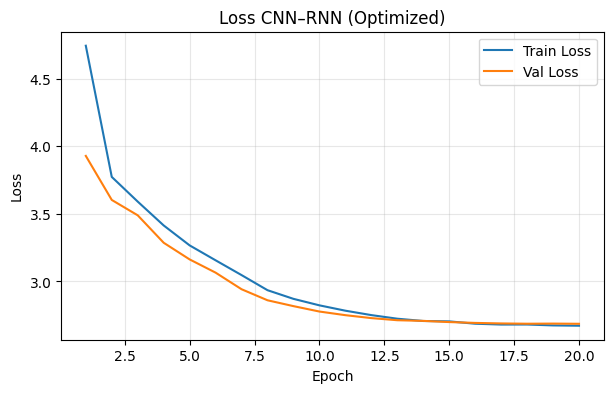

In [57]:
plt.figure(figsize=(7,4))
plt.plot(hist_opt["epoch"], hist_opt["train"], label="Train Loss")
plt.plot(hist_opt["epoch"], hist_opt["val"], label="Val Loss")
plt.title("Loss CNN–RNN (Optimized)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(); plt.grid(alpha=0.3)
plt.savefig(os.path.join(VIS_DIR, f"cnn_rnn_loss_curve_{time.strftime('%Y%m%d_%H%M')}.png"))
plt.show()

In [58]:
baseline_path = os.path.join(CHECKPOINT_DIR, "cnn_rnn_attn_best.pt")
cnn_rnn_base = CaptionModel(VOCAB_SIZE, PAD_IDX).to(DEVICE)
cnn_rnn_base.load_state_dict(torch.load(baseline_path, map_location=DEVICE))
cnn_rnn_base.eval()

metrics_base = evaluate_model(cnn_rnn_base, val_df, max_samples=300)
print("Kết quả CNN–RNN (Trước tối ưu):")
for k, v in metrics_base.items():
    print(f"{k:10s}: {v:.4f}")

optimized_path = os.path.join(CHECKPOINT_DIR, "cnn_rnn_best_optimized.pt")
cnn_rnn_opt = CaptionModel(VOCAB_SIZE, PAD_IDX).to(DEVICE)
cnn_rnn_opt.load_state_dict(torch.load(optimized_path, map_location=DEVICE))
cnn_rnn_opt.eval()

metrics_opt = evaluate_model(cnn_rnn_opt, val_df, max_samples=300)
print("\nKết quả CNN–RNN (Sau tối ưu):")
for k, v in metrics_opt.items():
    print(f"{k:10s}: {v:.4f}")


Kết quả CNN–RNN (Trước tối ưu):
BLEU-1    : 0.5942
BLEU-2    : 0.3801
BLEU-3    : 0.2252
BLEU-4    : 0.1335
METEOR    : 0.3619
ROUGE-1   : 0.5011
ROUGE-L   : 0.4794

Kết quả CNN–RNN (Sau tối ưu):
BLEU-1    : 0.6601
BLEU-2    : 0.4620
BLEU-3    : 0.3105
BLEU-4    : 0.2044
METEOR    : 0.4316
ROUGE-1   : 0.5512
ROUGE-L   : 0.5199


/tmp/ipykernel_1563603/1152790600.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/bbsw/truong/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


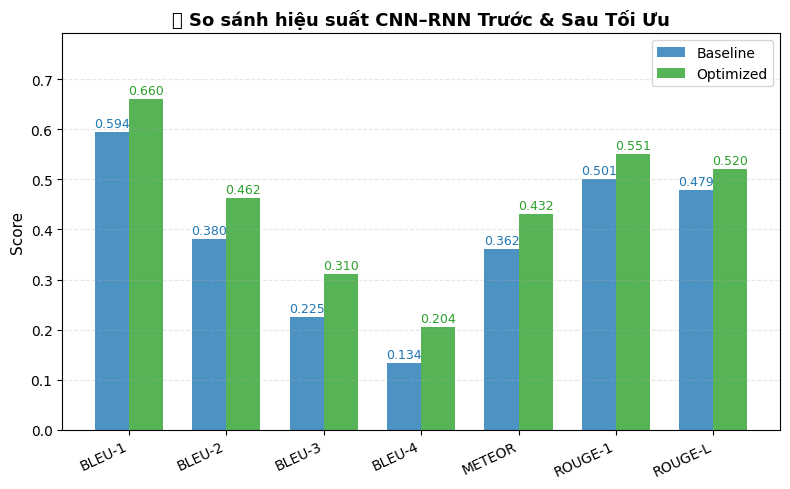

In [59]:
import matplotlib.pyplot as plt
import numpy as np

metrics_names = list(metrics_base.keys())
baseline_values = [metrics_base[k] for k in metrics_names]
optimized_values = [metrics_opt[k] for k in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35  # độ rộng mỗi cột

plt.figure(figsize=(8,5))
plt.bar(x - width/2, baseline_values, width, label='Baseline', color='#1f77b4', alpha=0.8)
plt.bar(x + width/2, optimized_values, width, label='Optimized', color='#2ca02c', alpha=0.8)

plt.title("📊 So sánh hiệu suất CNN–RNN Trước & Sau Tối Ưu", fontsize=13, weight='bold')
plt.ylabel("Score", fontsize=11)
plt.xticks(x, metrics_names, rotation=25, ha='right', fontsize=10)
plt.ylim(0, max(max(baseline_values), max(optimized_values)) * 1.2)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

for i, v in enumerate(baseline_values):
    plt.text(x[i] - width/2, v + 0.01, f"{v:.3f}", ha='center', fontsize=9, color='#1f77b4')
for i, v in enumerate(optimized_values):
    plt.text(x[i] + width/2, v + 0.01, f"{v:.3f}", ha='center', fontsize=9, color='#2ca02c')

plt.tight_layout()
plt.show()


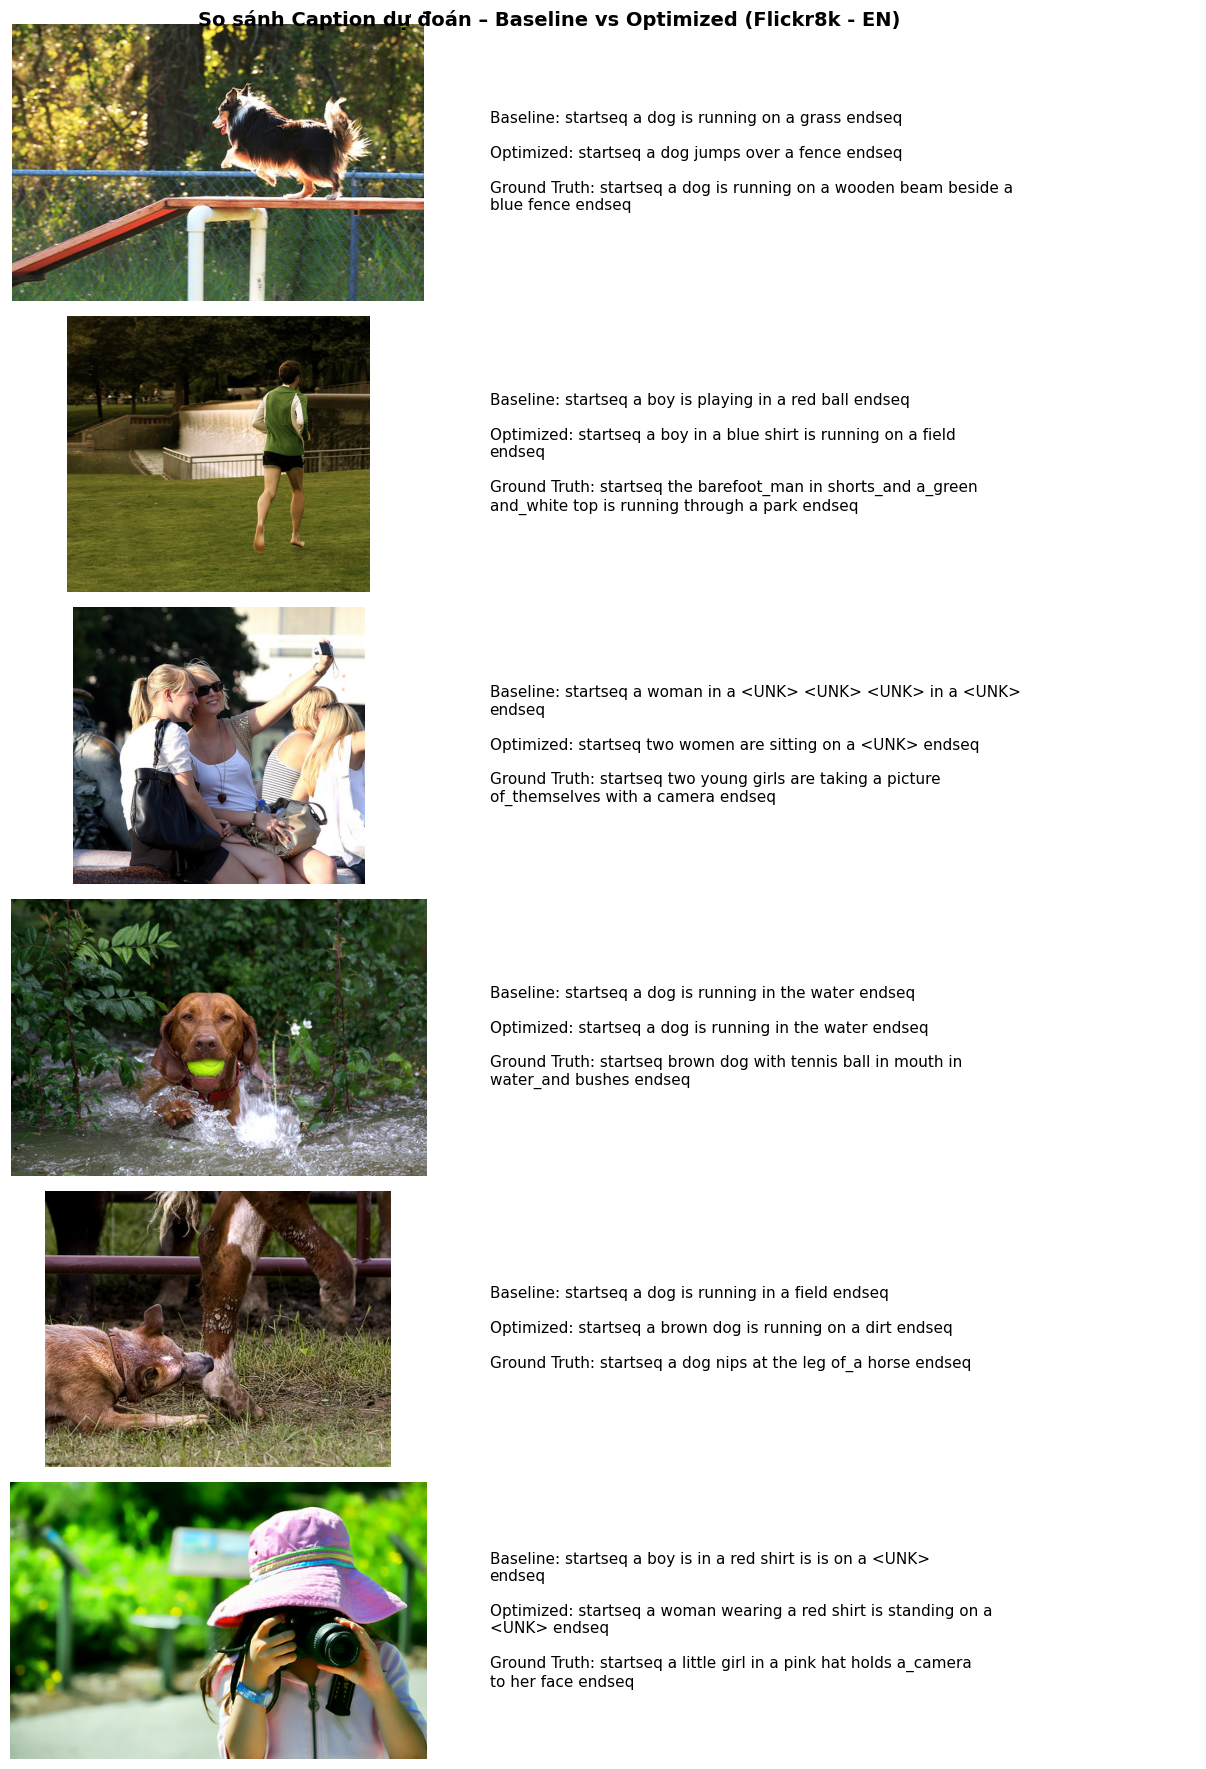

In [62]:
sample_imgs = random.sample(list(val_df["image"].unique()), 6)

plt.figure(figsize=(14, 18))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(DATA_IMG_DIR, img_name)
    if not os.path.exists(img_path):
        continue

    # Caption dự đoán bởi 2 model
    pred_base = generate_caption(cnn_rnn_base, img_path, vocab_en)
    pred_opt  = generate_caption(cnn_rnn_opt, img_path, vocab_en)

    # Caption thực tế
    if img_name in train_df["image"].values:
        gt_list = train_df[train_df["image"] == img_name]["caption"].tolist()
    else:
        gt_list = val_df[val_df["image"] == img_name]["caption"].tolist()
    gt = random.choice(gt_list)

    # Ảnh hiển thị bên trái
    plt.subplot(len(sample_imgs), 2, 2*i + 1)
    plt.imshow(Image.open(img_path).convert("RGB"))
    plt.axis("off")

    # Caption hiển thị bên phải
    text_base = "\n".join(textwrap.wrap(f"Baseline:\n{pred_base}", 65))
    text_opt  = "\n".join(textwrap.wrap(f"Optimized:\n{pred_opt}", 65))
    text_gt   = "\n".join(textwrap.wrap(f"Ground Truth:\n{gt}", 65))

    plt.subplot(len(sample_imgs), 2, 2*i + 2)
    plt.text(
        0, 0.5,
        f"{text_base}\n\n{text_opt}\n\n{text_gt}",
        fontsize=11, va='center', wrap=True
    )
    plt.axis("off")

plt.suptitle(
    "So sánh Caption dự đoán – Baseline vs Optimized (Flickr8k - EN)",
    fontsize=14, fontweight="bold"
)
plt.tight_layout()
plt.show()

### e) Ứng dụng mô hình Transformer:
Triển khai mô hình image captioning sử dụng kiến trúc **Vision Transformer (ViT)** kết hợp với **Transformer Decoder** (ví dụ GPT2 hoặc BART). 

Khai thác pretrained model từ thư viện **Transformers (HuggingFace)**. 

So sánh kết quả dự đoán với mô hình CNN–RNN truyền thống (về độ chính xác, BLEU score, tốc độ huấn luyện).

In [8]:
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
from torchvision import transforms
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from transformers import (
    ViTModel, GPT2LMHeadModel, GPT2Tokenizer, get_linear_schedule_with_warmup
)
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


2025-11-09 19:02:33.878752: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 19:02:34.272218: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/bbsw/truong/.venv/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.12) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.ap

In [30]:
import pickle
import os
ROOT_DIR = "/home/bbsw/truong/thuchang"
SAVE_DIR = os.path.join(ROOT_DIR, "model_en/data/processed")

vocab_en = VocabularyEN(freq_threshold=5)
with open(os.path.join(SAVE_DIR, "vocab_en.pkl"), "rb") as f:
    vocab_en = pickle.load(f)
stoi = vocab_en.stoi
itos = vocab_en.itos
PAD_IDX = vocab_en.stoi["<PAD>"]
SOS_IDX = vocab_en.stoi["<SOS>"]
EOS_IDX = vocab_en.stoi["<EOS>"]
UNK_IDX = vocab_en.stoi["<UNK>"]
VOCAB_SIZE = len(vocab_en)
print(f"Loaded vocab: {VOCAB_SIZE} words")
print(f"PAD_IDX: {PAD_IDX}")
print(f"SOS_IDX: {SOS_IDX}")
print(f"EOS_IDX: {EOS_IDX}")
print(f"UNK_IDX: {UNK_IDX}")
print(f"Sample stoi: {list(stoi.items())[:10]}")
print(f"Sample itos: {list(itos.items())[:10]}")

Loaded vocab: 4512 words
PAD_IDX: 0
SOS_IDX: 1
EOS_IDX: 2
UNK_IDX: 3
Sample stoi: [('<PAD>', 0), ('<SOS>', 1), ('<EOS>', 2), ('<UNK>', 3), ('a', 4), ('startseq', 5), ('endseq', 6), ('in', 7), ('the', 8), ('on', 9)]
Sample itos: [(0, '<PAD>'), (1, '<SOS>'), (2, '<EOS>'), (3, '<UNK>'), (4, 'a'), (5, 'startseq'), (6, 'endseq'), (7, 'in'), (8, 'the'), (9, 'on')]


In [10]:
class VisionEncoderDecoderModel(nn.Module):
    """Vision Transformer Encoder + GPT2 Decoder (with Cross-Attention)

    Improvements made:
    - projection from ViT hidden -> GPT2 embedding dim
    - added optional beam search for generation
    - keep code robust if ViT encoder layer naming differs
    """
    def __init__(self, vit_model_name='google/vit-base-patch16-224',
                 gpt2_model_name='gpt2', max_length=50, n_heads=12):
        super().__init__()
        self.vit = ViTModel.from_pretrained(vit_model_name)
        self.vit_hidden = self.vit.config.hidden_size

        self.gpt2 = GPT2LMHeadModel.from_pretrained(gpt2_model_name)
        self.gpt2_hidden = self.gpt2.config.n_embd

        # projection for vision features -> gpt2 embedding space
        self.vision_proj = nn.Linear(self.vit_hidden, self.gpt2_hidden)

        # Cross-attention implemented as a MultiheadAttention that attends from tokens -> visual tokens
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.gpt2_hidden, num_heads=n_heads, dropout=0.1, batch_first=True
        )
        self.ln = nn.LayerNorm(self.gpt2_hidden)
        self.max_length = max_length

    def forward(self, pixel_values, input_ids, attention_mask=None):
        # pixel_values: (B, C, H, W)
        vis_out = self.vit(pixel_values=pixel_values).last_hidden_state  # (B, N, vit_hidden)
        vis_feat = self.vision_proj(vis_out)  # (B, N, gpt2_hidden)

        # token embeddings from GPT2
        tok_emb = self.gpt2.transformer.wte(input_ids)  # (B, T, gpt2_hidden)

        # cross attention: queries=token_embeddings, keys/values = vis_feat
        attn_out, _ = self.cross_attn(tok_emb, vis_feat, vis_feat)
        combined = self.ln(tok_emb + attn_out)

        outputs = self.gpt2(inputs_embeds=combined, attention_mask=attention_mask, return_dict=True)
        return outputs.logits

    @torch.no_grad()
    def generate_caption(self, pixel_values, tokenizer, max_length=None, device="cuda", beam_k=1, length_penalty=1.0):
        """Generate caption; supports greedy (beam_k=1) and simple beam search (beam_k>1).
        This method performs generation in embedding space by repeatedly calling GPT2 with inputs_embeds.
        """
        self.eval()
        if max_length is None:
            max_length = self.max_length

        # prepare visual features once
        vis_out = self.vit(pixel_values=pixel_values.to(device)).last_hidden_state
        vis_feat = self.vision_proj(vis_out)  # (1, N, d)

        bos_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.cls_token_id
        eos_id = tokenizer.eos_token_id

        if beam_k is None or beam_k <= 1:
            # greedy
            input_ids = torch.tensor([[bos_id]], device=device)
            for _ in range(max_length):
                tok_emb = self.gpt2.transformer.wte(input_ids)
                attn_out, _ = self.cross_attn(tok_emb, vis_feat, vis_feat)
                combined = self.ln(tok_emb + attn_out)
                outputs = self.gpt2(inputs_embeds=combined, return_dict=True)
                logits = outputs.logits[:, -1, :]
                next_token = torch.argmax(logits, dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)
                if next_token.item() == eos_id:
                    break
            return tokenizer.decode(input_ids[0], skip_special_tokens=True)

        # Simple beam search
        # Each hypothesis is (input_ids_tensor, score)
        hypotheses = [(torch.tensor([bos_id], device=device), 0.0)]
        for _ in range(max_length):
            all_candidates = []
            for seq, score in hypotheses:
                seq = seq.unsqueeze(0)  # (1, L)
                tok_emb = self.gpt2.transformer.wte(seq)
                attn_out, _ = self.cross_attn(tok_emb, vis_feat, vis_feat)
                combined = self.ln(tok_emb + attn_out)
                outputs = self.gpt2(inputs_embeds=combined, return_dict=True)
                logits = outputs.logits[:, -1, :]
                log_probs = F.log_softmax(logits, dim=-1).squeeze(0)  # (V,)

                topk = torch.topk(log_probs, k=min(beam_k, log_probs.size(0)))
                for k_i in range(topk.indices.size(0)):
                    idx = topk.indices[k_i].unsqueeze(0)
                    nscore = score + topk.values[k_i].item()
                    new_seq = torch.cat([seq.squeeze(0), idx.to(device)], dim=0)
                    all_candidates.append((new_seq, nscore))

            # select best beam_k
            ordered = sorted(all_candidates, key=lambda x: x[1] / (len(x[0]) ** length_penalty), reverse=True)
            hypotheses = ordered[:beam_k]

            # if any hypothesis ends with EOS, optionally stop early if top hypothesis ended
            if any(h[0][-1].item() == eos_id for h in hypotheses):
                break

        best_seq = hypotheses[0][0]
        return tokenizer.decode(best_seq.cpu().numpy().tolist(), skip_special_tokens=True)


In [11]:
def collate_fn_transformer(batch):
    pixels, ids, masks = zip(*batch)
    return torch.stack(pixels), torch.stack(ids), torch.stack(masks)

def _unfreeze_last_vit_layers(model, n_unfreeze=2):
    """Unfreeze last n transformer blocks of ViT if possible; otherwise unfreeze entire vit."""
    if hasattr(model.vit, 'encoder') and hasattr(model.vit.encoder, 'layer'):
        layers = list(model.vit.encoder.layer)
        total = len(layers)
        for i, layer in enumerate(layers):
            requires = (i >= total - n_unfreeze)
            for p in layer.parameters():
                p.requires_grad = requires
        print(f"🔧 Unfroze last {n_unfreeze} ViT layers (out of {total})")
    else:
        for p in model.vit.parameters():
            p.requires_grad = True
        print("🔧 ViT encoder layer structure not detected — unfroze entire ViT")


def train_transformer_model(model, train_loader, val_loader, tokenizer,
                            num_epochs=10, lr=5e-5, device="cuda",
                            freeze_vit_epochs=1, patience=3, n_unfreeze_vit_layers=4):
    """
    Huấn luyện mô hình ViT + GPT2 theo 2 giai đoạn:
    1) freeze_vit_epochs đầu: chỉ train phần GPT2 (decoder)
    2) các epoch sau: unfreeze last-n ViT blocks (or whole ViT) và fine-tune
    + Mixed precision (autocast + GradScaler)
    """
    model.to(device)

    # Ensure some params are trainable (vision_proj, cross_attn, ln, gpt2)
    for p in model.vit.parameters():
        p.requires_grad = False

    # Parameter groups with conservative lrs for vision and larger for decoder
    optimizer = AdamW([
        {"params": [p for p in model.vit.parameters() if p.requires_grad], "lr": 1e-5},
        {"params": model.gpt2.parameters(), "lr": 2e-5},
        {"params": model.vision_proj.parameters(), "lr": 3e-5},
        {"params": model.cross_attn.parameters(), "lr": 3e-5},
        {"params": model.ln.parameters(), "lr": 3e-5},
    ], weight_decay=1e-2)

    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=max(1, total_steps // 10), num_training_steps=total_steps
    )
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    scaler = torch.cuda.amp.GradScaler()

    train_losses, val_losses = [], []
    best_val = float("inf")
    no_improve_epochs = 0  # Early stopping counter

    # report trainable params
    def count_trainable():
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable params at start: {count_trainable():,}")

    for ep in range(1, num_epochs + 1):
        # Freeze stage
        if ep == 1:
            print(f"🔒 Freezing ViT for first {freeze_vit_epochs} epoch(s)")
            for p in model.vit.parameters():
                p.requires_grad = False
            for p in model.cross_attn.parameters():
                p.requires_grad = True  # keep cross-attn trainable actually

        # Unfreeze stage
        if ep == freeze_vit_epochs + 1:
            # unfreeze last-n layers
            _unfreeze_last_vit_layers(model, n_unfreeze=n_unfreeze_vit_layers)

        model.train(); total_tr = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {ep}/{num_epochs} [Train]")
        for batch in pbar:
            pixels, ids, mask = [b.to(device) for b in batch]
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=True):
                logits = model(pixels, ids[:, :-1], mask[:, :-1])
                loss = criterion(logits.reshape(-1, logits.size(-1)), ids[:, 1:].reshape(-1))
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            total_tr += loss.item()
            pbar.set_postfix(train_loss=f"{loss.item():.4f}")
        avg_tr = total_tr / len(train_loader)

        # VALIDATION
        model.eval(); total_val = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {ep}/{num_epochs} [Val]"):
                pixels, ids, mask = [b.to(device) for b in batch]
                with torch.cuda.amp.autocast(enabled=True):
                    logits = model(pixels, ids[:, :-1], mask[:, :-1])
                    loss = criterion(logits.reshape(-1, logits.size(-1)), ids[:, 1:].reshape(-1))
                total_val += loss.item()
        avg_val = total_val / len(val_loader)

        train_losses.append(avg_tr); val_losses.append(avg_val)
        print(f"Epoch {ep}: Train {avg_tr:.4f} | Val {avg_val:.4f}")

        # Early stopping
        if avg_val < best_val - 1e-4:
            best_val = avg_val
            no_improve_epochs = 0
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "best_vit_gpt2.pth"))
            print("✅ Saved best model")
        else:
            no_improve_epochs += 1
            print(f"⚠️ No improvement ({no_improve_epochs}/{patience})")
            if no_improve_epochs >= patience:
                print("⏹️ Early stopping triggered!")
                break

    print(f"Trainable params at end: {count_trainable():,}")
    return train_losses, val_losses

In [12]:
import os, re
from collections import Counter
from typing import Iterable, Optional, List, Set
from transformers import GPT2Tokenizer

class ExtendedGPT2TokenizerManager:
    """
    Xây một tokenizer GPT-2 mở rộng:
    - Thêm special tokens: <bos>, </eos>, <pad>
    - Nhập thêm các token tùy ý (từ vocab cũ hoặc tự suy ra từ corpus)
    - Lưu/Load bằng save_pretrained / from_pretrained
    """
    DEFAULT_SPECIALS = {
        "bos_token": "<bos>",
        "eos_token": "</eos>",
        "pad_token": "<pad>",
    }
    # Các token từ vocab cũ nên bỏ vì đã có special mới
    DROP_TOKENS: Set[str] = {"<PAD>", "<SOS>", "<EOS>", "<UNK>", "startseq", "endseq"}

    def __init__(self, base_model: str = "gpt2"):
        self.base_model = base_model
        self.tokenizer: Optional[GPT2Tokenizer] = None

    def _sanitize_candidates(self, candidates: Iterable[str]) -> List[str]:
        out = []
        for w in candidates:
            if not w or w in self.DROP_TOKENS:
                continue
            # bỏ khoảng trắng đầu/cuối
            w = w.strip()
            # bỏ token quá dài kỳ quặc
            if len(w) > 40:
                continue
            out.append(w)
        return out

    def build_from_vocab_en(self, vocab_en, save_dir: str) -> GPT2Tokenizer:
        """
        Xây tokenizer từ GPT-2 + thêm token từ vocab_en.stoi (bỏ special & start/end seq).
        """
        tok = GPT2Tokenizer.from_pretrained(self.base_model)
        tok.add_special_tokens(self.DEFAULT_SPECIALS)

        base_vocab = set(tok.get_vocab().keys())
        # lấy toàn bộ token ứng viên từ vocab_en
        candidates = list(vocab_en.stoi.keys())
        candidates = self._sanitize_candidates(candidates)

        new_tokens = [w for w in candidates if w not in base_vocab]
        if new_tokens:
            added = tok.add_tokens(new_tokens, special_tokens=False)
            print(f"✅ Added {added} new tokens from vocab_en")

        os.makedirs(save_dir, exist_ok=True)
        tok.save_pretrained(save_dir)

        print(f"✅ Extended tokenizer saved to: {save_dir}")
        print(f"   size={len(tok)}, BOS={tok.bos_token_id}, EOS={tok.eos_token_id}, PAD={tok.pad_token_id}")
        self.tokenizer = tok
        return tok

    def build_from_corpus(self, captions: Iterable[str], save_dir: str,
                          min_count: int = 10) -> GPT2Tokenizer:
        """
        (Tuỳ chọn) Xây tokenizer GPT-2 + thêm một số token domain-specific từ corpus.
        Ở đây ví dụ: thêm các token chứa dấu gạch dưới/viết liền (vd: 'a_man', 'red_dress')
        hoặc các từ xuất hiện >= min_count (nhẹ nhàng, tránh thêm quá nhiều).
        """
        tok = GPT2Tokenizer.from_pretrained(self.base_model)
        tok.add_special_tokens(self.DEFAULT_SPECIALS)
        base_vocab = set(tok.get_vocab().keys())

        # ví dụ: trích token kiểu có '_' hoặc chuỗi liền không có khoảng trắng
        freq = Counter()
        for s in captions:
            s = s.strip()
            # giữ nguyên gốc để gpt2 xử lý bpe; nhưng tìm "từ lạ" kiểu có underscore:
            for w in re.findall(r"[A-Za-z]+(?:_[A-Za-z]+)+", s):
                freq[w] += 1

        # thêm cả một số từ thường gặp (nhưng cẩn thận không thêm quá nhiều)
        plain = Counter()
        for s in captions:
            for w in re.findall(r"[A-Za-z]+", s.lower()):
                plain[w] += 1

        candidates = [w for w, c in freq.items() if c >= 2]  # underscore token
        candidates += [w for w, c in plain.items() if c >= min_count and len(w) > 3]

        candidates = self._sanitize_candidates(set(candidates))
        new_tokens = [w for w in candidates if w not in base_vocab]
        if new_tokens:
            added = tok.add_tokens(new_tokens, special_tokens=False)
            print(f"✅ Added {added} new tokens from corpus (min_count={min_count})")

        os.makedirs(save_dir, exist_ok=True)
        tok.save_pretrained(save_dir)
        print(f"✅ Extended tokenizer saved to: {save_dir}")
        print(f"   size={len(tok)}, BOS={tok.bos_token_id}, EOS={tok.eos_token_id}, PAD={tok.pad_token_id}")
        self.tokenizer = tok
        return tok

    @staticmethod
    def load(save_dir: str) -> GPT2Tokenizer:
        tok = GPT2Tokenizer.from_pretrained(save_dir)
        print(f"✅ Loaded extended tokenizer from {save_dir} (size={len(tok)})")
        return tok

class FlickrDatasetGPT2(Dataset):
    def __init__(self, df, img_root, tokenizer, max_len=50):
        self.df = df.reset_index(drop=True)
        self.img_root = img_root
        self.tok = tokenizer
        self.max_len = max_len
        self.tf = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img_path = os.path.join(self.img_root, row["image"])
        img = Image.open(img_path).convert("RGB")
        px = self.tf(img)

        # làm sạch caption
        text = row["caption"].replace("startseq","").replace("endseq","").strip()

        # encode: (không rely add_special_tokens, tự thêm bos/eos để chắc chắn)
        ids = self.tok.encode(text, add_special_tokens=False)
        ids = [self.tok.bos_token_id] + ids + [self.tok.eos_token_id]
        if len(ids) > self.max_len:
            ids = ids[:self.max_len]
        attn = [1]*len(ids)

        return px, torch.tensor(ids, dtype=torch.long), torch.tensor(attn, dtype=torch.long)


class GPT2PadCollator:
    # Collate: pad theo tokenizer.pad_token_id, sinh attention_mask nhị phân.
    def __init__(self, pad_id: int):
        self.pad_id = pad_id

    def __call__(self, batch):
        pxs, ids, attn = zip(*batch)
        pxs = torch.stack(pxs)
        T = max(x.size(0) for x in ids)

        ids_pad  = torch.full((len(ids), T), self.pad_id, dtype=torch.long)
        mask_pad = torch.zeros((len(ids), T), dtype=torch.long)

        for i, seq in enumerate(ids):
            L = seq.size(0)
            ids_pad[i, :L] = seq
            mask_pad[i, :L] = 1

        return pxs, ids_pad, mask_pad


In [75]:
tok_mgr = ExtendedGPT2TokenizerManager(base_model="gpt2")
TOK_DIR = os.path.join(SAVE_DIR, "tokenizer_gpt2_extended")
tokenizer_en = tok_mgr.build_from_vocab_en(vocab_en, save_dir=TOK_DIR)
tokenizer_en = ExtendedGPT2TokenizerManager.load(TOK_DIR)
collate = GPT2PadCollator(pad_id=tokenizer_en.pad_token_id)
train_loader = DataLoader(
    FlickrDatasetGPT2(train_df, DATA_IMG_DIR, tokenizer_en, max_len=50),
    batch_size=32, shuffle=True, num_workers=4, collate_fn=collate
)
val_loader = DataLoader(
    FlickrDatasetGPT2(val_df, DATA_IMG_DIR, tokenizer_en, max_len=50),
    batch_size=32, shuffle=False, num_workers=4, collate_fn=collate
)
model_en = VisionEncoderDecoderModel(
    vit_model_name='google/vit-base-patch16-224',
    gpt2_model_name='gpt2',
    max_length=50
).to(DEVICE)

# resize để GPT-2 tokenizer mới
model_en.gpt2.resize_token_embeddings(len(tokenizer_en))
train_losses, val_losses = train_transformer_model(model_en, train_loader, val_loader, tokenizer_en, num_epochs=20, device=DEVICE)


✅ Added 3363 new tokens from vocab_en
✅ Extended tokenizer saved to: /home/bbsw/truong/thuchang/model_en/data/processed/tokenizer_gpt2_extended
   size=53623, BOS=50257, EOS=50258, PAD=50259
✅ Loaded extended tokenizer from /home/bbsw/truong/thuchang/model_en/data/processed/tokenizer_gpt2_extended (size=53623)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/tmp/ipykernel_1563603/4132768731.py:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Trainable params at start: 129,979,392
🔒 Freezing ViT for first 1 epoch(s)


Epoch 1/20 [Train]:   0%|          | 0/1012 [00:00<?, ?it/s]/tmp/ipykernel_1563603/4132768731.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
Epoch 1/20 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]/tmp/ipykernel_1563603/4132768731.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
Epoch 1/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 31.83it/s]


Epoch 1: Train 6.1171 | Val 3.7541
✅ Saved best model
🔧 Unfroze last 4 ViT layers (out of 12)


Epoch 2/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 31.79it/s]


Epoch 2: Train 3.8327 | Val 3.6708
✅ Saved best model


Epoch 3/20 [Val]: 100%|██████████| 127/127 [00:04<00:00, 31.30it/s]


Epoch 3: Train 3.7366 | Val 3.5919
✅ Saved best model


Epoch 4/20 [Val]: 100%|██████████| 127/127 [00:04<00:00, 31.72it/s]


Epoch 4: Train 3.6602 | Val 3.5224
✅ Saved best model


Epoch 5/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 32.96it/s]


Epoch 5: Train 3.5696 | Val 3.4349
✅ Saved best model


Epoch 6/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 32.15it/s]


Epoch 6: Train 3.4628 | Val 3.3306
✅ Saved best model


Epoch 7/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 32.65it/s]


Epoch 7: Train 3.3373 | Val 3.2287
✅ Saved best model


Epoch 8/20 [Val]: 100%|██████████| 127/127 [00:04<00:00, 31.59it/s]


Epoch 8: Train 3.2139 | Val 3.1255
✅ Saved best model


Epoch 9/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 32.67it/s]


Epoch 9: Train 3.0891 | Val 3.0201
✅ Saved best model


Epoch 10/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 32.15it/s]


Epoch 10: Train 2.9534 | Val 2.8921
✅ Saved best model


Epoch 11/20 [Val]: 100%|██████████| 127/127 [00:04<00:00, 30.77it/s]


Epoch 11: Train 2.7865 | Val 2.7669
✅ Saved best model


Epoch 12/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 32.59it/s]


Epoch 12: Train 2.6575 | Val 2.6940
✅ Saved best model


Epoch 13/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 32.86it/s]


Epoch 13: Train 2.5847 | Val 2.6567
✅ Saved best model


Epoch 14/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 31.87it/s]


Epoch 14: Train 2.5321 | Val 2.6229
✅ Saved best model


Epoch 15/20 [Val]: 100%|██████████| 127/127 [00:04<00:00, 31.60it/s]


Epoch 15: Train 2.4864 | Val 2.5840
✅ Saved best model


Epoch 16/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 32.24it/s]


Epoch 16: Train 2.4398 | Val 2.5577
✅ Saved best model


Epoch 17/20 [Val]: 100%|██████████| 127/127 [00:03<00:00, 32.57it/s]


Epoch 17: Train 2.4025 | Val 2.5363
✅ Saved best model


Epoch 18/20 [Val]: 100%|██████████| 127/127 [00:04<00:00, 30.85it/s]


Epoch 18: Train 2.3723 | Val 2.5206
✅ Saved best model


Epoch 19/20 [Val]: 100%|██████████| 127/127 [00:04<00:00, 31.55it/s]


Epoch 19: Train 2.3529 | Val 2.5136
✅ Saved best model


Epoch 20/20 [Val]: 100%|██████████| 127/127 [00:04<00:00, 30.57it/s]


Epoch 20: Train 2.3407 | Val 2.5095
✅ Saved best model
Trainable params at end: 158,330,880


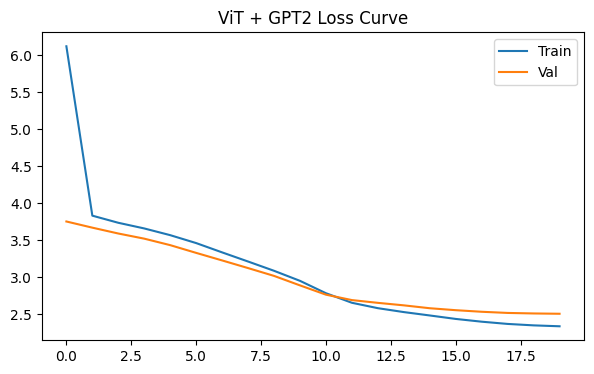

In [76]:
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train"); plt.plot(val_losses, label="Val")
plt.legend()
plt.title("ViT + GPT2 Loss Curve") 
plt.show()

In [25]:
# import torch
# from PIL import Image
# from tqdm import tqdm
import numpy as np
# from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# from nltk.translate.meteor_score import meteor_score
# from rouge_score import rouge_scorer

def evaluate_caption_model(df, model, tokenizer, img_dir, device="cuda",
                           max_samples=300, beam_k=3, max_length=50, transform=None):
    # sample subset
    # if len(df) > max_samples:
    df_eval = df.sample(n=max_samples, random_state=42).reset_index(drop=True)
    # else:
    #     df_eval = df.copy()

    if transform is None:
        from torchvision import transforms
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
        ])

    generated_captions = []
    references = []

    model.eval()
    with torch.no_grad():
        for _, row in tqdm(df_eval.iterrows(), total=len(df_eval)):
            img_path = os.path.join(img_dir, row["image"])
            img = Image.open(img_path).convert("RGB")
            pixel_values = transform(img).unsqueeze(0).to(device)

            # generate caption
            caption = model.generate_caption(pixel_values, tokenizer,
                                             max_length=max_length,
                                             device=device,
                                             beam_k=beam_k)
            generated_captions.append(caption)
            references.append([row["caption"]])

    # BLEU
    smooth = SmoothingFunction().method1
    bleu1 = corpus_bleu(references, generated_captions, weights=(1,0,0,0), smoothing_function=smooth)
    bleu2 = corpus_bleu(references, generated_captions, weights=(0.5,0.5,0,0), smoothing_function=smooth)
    bleu3 = corpus_bleu(references, generated_captions, weights=(0.33,0.33,0.33,0), smoothing_function=smooth)
    bleu4 = corpus_bleu(references, generated_captions, weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth)

    # METEOR
    # meteors = [meteor_score(ref, hyp) for ref, hyp in zip(references, generated_captions)]
    # METEOR
    meteors = [
        meteor_score([r.split() for r in ref], hyp.split())
        for ref, hyp in zip(references, generated_captions)
    ]

    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
    r1, rL = [], []
    for ref, hyp in zip(references, generated_captions):
        scores = scorer.score(ref[0], hyp)
        r1.append(scores['rouge1'].fmeasure)
        rL.append(scores['rougeL'].fmeasure)

    metrics = {
        "BLEU-1": float(bleu1),
        "BLEU-2": float(bleu2),
        "BLEU-3": float(bleu3),
        "BLEU-4": float(bleu4),
        "METEOR": float(np.mean(meteors)) if meteors else 0.0,
        "ROUGE-1": float(np.mean(r1)) if r1 else 0.0,
        "ROUGE-L": float(np.mean(rL)) if rL else 0.0,
    }

    return metrics


In [26]:
tok_mgr = ExtendedGPT2TokenizerManager(base_model="gpt2")
TOK_DIR = os.path.join(SAVE_DIR, "tokenizer_gpt2_extended")
tokenizer_en = tok_mgr.build_from_vocab_en(vocab_en, save_dir=TOK_DIR)
tokenizer_en = ExtendedGPT2TokenizerManager.load(TOK_DIR)

model_en = VisionEncoderDecoderModel(
    vit_model_name='google/vit-base-patch16-224',
    gpt2_model_name='gpt2',
    max_length=50
).to(DEVICE)

# resize để GPT-2 tokenizer mới
model_en.gpt2.resize_token_embeddings(len(tokenizer_en))


✅ Added 3363 new tokens from vocab_en
✅ Extended tokenizer saved to: /home/bbsw/truong/thuchang/model_en/data/processed/tokenizer_gpt2_extended
   size=53623, BOS=50257, EOS=50258, PAD=50259
✅ Loaded extended tokenizer from /home/bbsw/truong/thuchang/model_en/data/processed/tokenizer_gpt2_extended (size=53623)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(53623, 768)

Beam search k=3

In [40]:
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "best_vit_gpt2.pth")
model_en.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
model_en.eval() 

metrics = evaluate_caption_model(
    val_df,
    model_en,
    tokenizer_en,
    img_dir=DATA_IMG_DIR,
    device=DEVICE,
    max_samples=300,
    beam_k=3,
    max_length=50
)

# print(metrics)
metrics_df_beam  = pd.DataFrame(list(metrics.items()), columns=["Metric", "Score"])
metrics_df_beam 

100%|██████████| 300/300 [00:57<00:00,  5.18it/s]


Metric     Score
0   BLEU-1  0.621317
1   BLEU-2  0.457226
2   BLEU-3  0.335793
3   BLEU-4  0.255100
4   METEOR  0.151388
5  ROUGE-1  0.267296
6  ROUGE-L  0.246925

In [41]:
# CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "best_vit_gpt2.pth")
# model_en.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
# model_en.eval() 

metrics = evaluate_caption_model(
    val_df,
    model_en,
    tokenizer_en,
    img_dir=DATA_IMG_DIR,
    device=DEVICE,
    max_samples=300,
    beam_k=1,
    max_length=50
)

metrics_df_greedy = pd.DataFrame(list(metrics.items()), columns=["Metric", "Score"])
metrics_df_greedy


100%|██████████| 300/300 [00:24<00:00, 12.17it/s]


Metric     Score
0   BLEU-1  0.627961
1   BLEU-2  0.446994
2   BLEU-3  0.318440
3   BLEU-4  0.234640
4   METEOR  0.123532
5  ROUGE-1  0.234672
6  ROUGE-L  0.223546

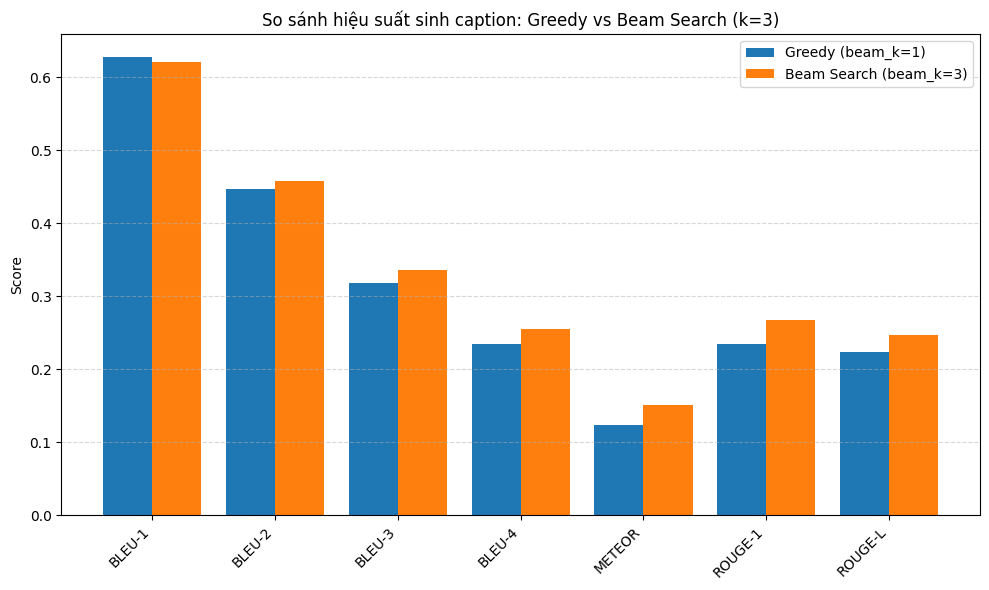

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

metrics_df_greedy["Decoding"] = "Greedy (beam_k=1)"
metrics_df_beam["Decoding"] = "Beam Search (beam_k=3)"

metrics_all = pd.concat([metrics_df_greedy, metrics_df_beam], ignore_index=True)
metrics_wide = metrics_all.pivot(index="Metric", columns="Decoding", values="Score").reset_index()
metrics_wide = metrics_wide.sort_values("Metric")
plt.figure(figsize=(10, 6))
x = range(len(metrics_wide))
bar_w = 0.4

plt.bar([i - bar_w/2 for i in x],
        metrics_wide["Greedy (beam_k=1)"],
        width=bar_w,
        label="Greedy (beam_k=1)")

plt.bar([i + bar_w/2 for i in x],
        metrics_wide["Beam Search (beam_k=3)"],
        width=bar_w,
        label="Beam Search (beam_k=3)")

# Nhãn và tiêu đề
plt.xticks(list(x), metrics_wide["Metric"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("So sánh hiệu suất sinh caption: Greedy vs Beam Search (k=3)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# ✅ Hiển thị biểu đồ
plt.show()


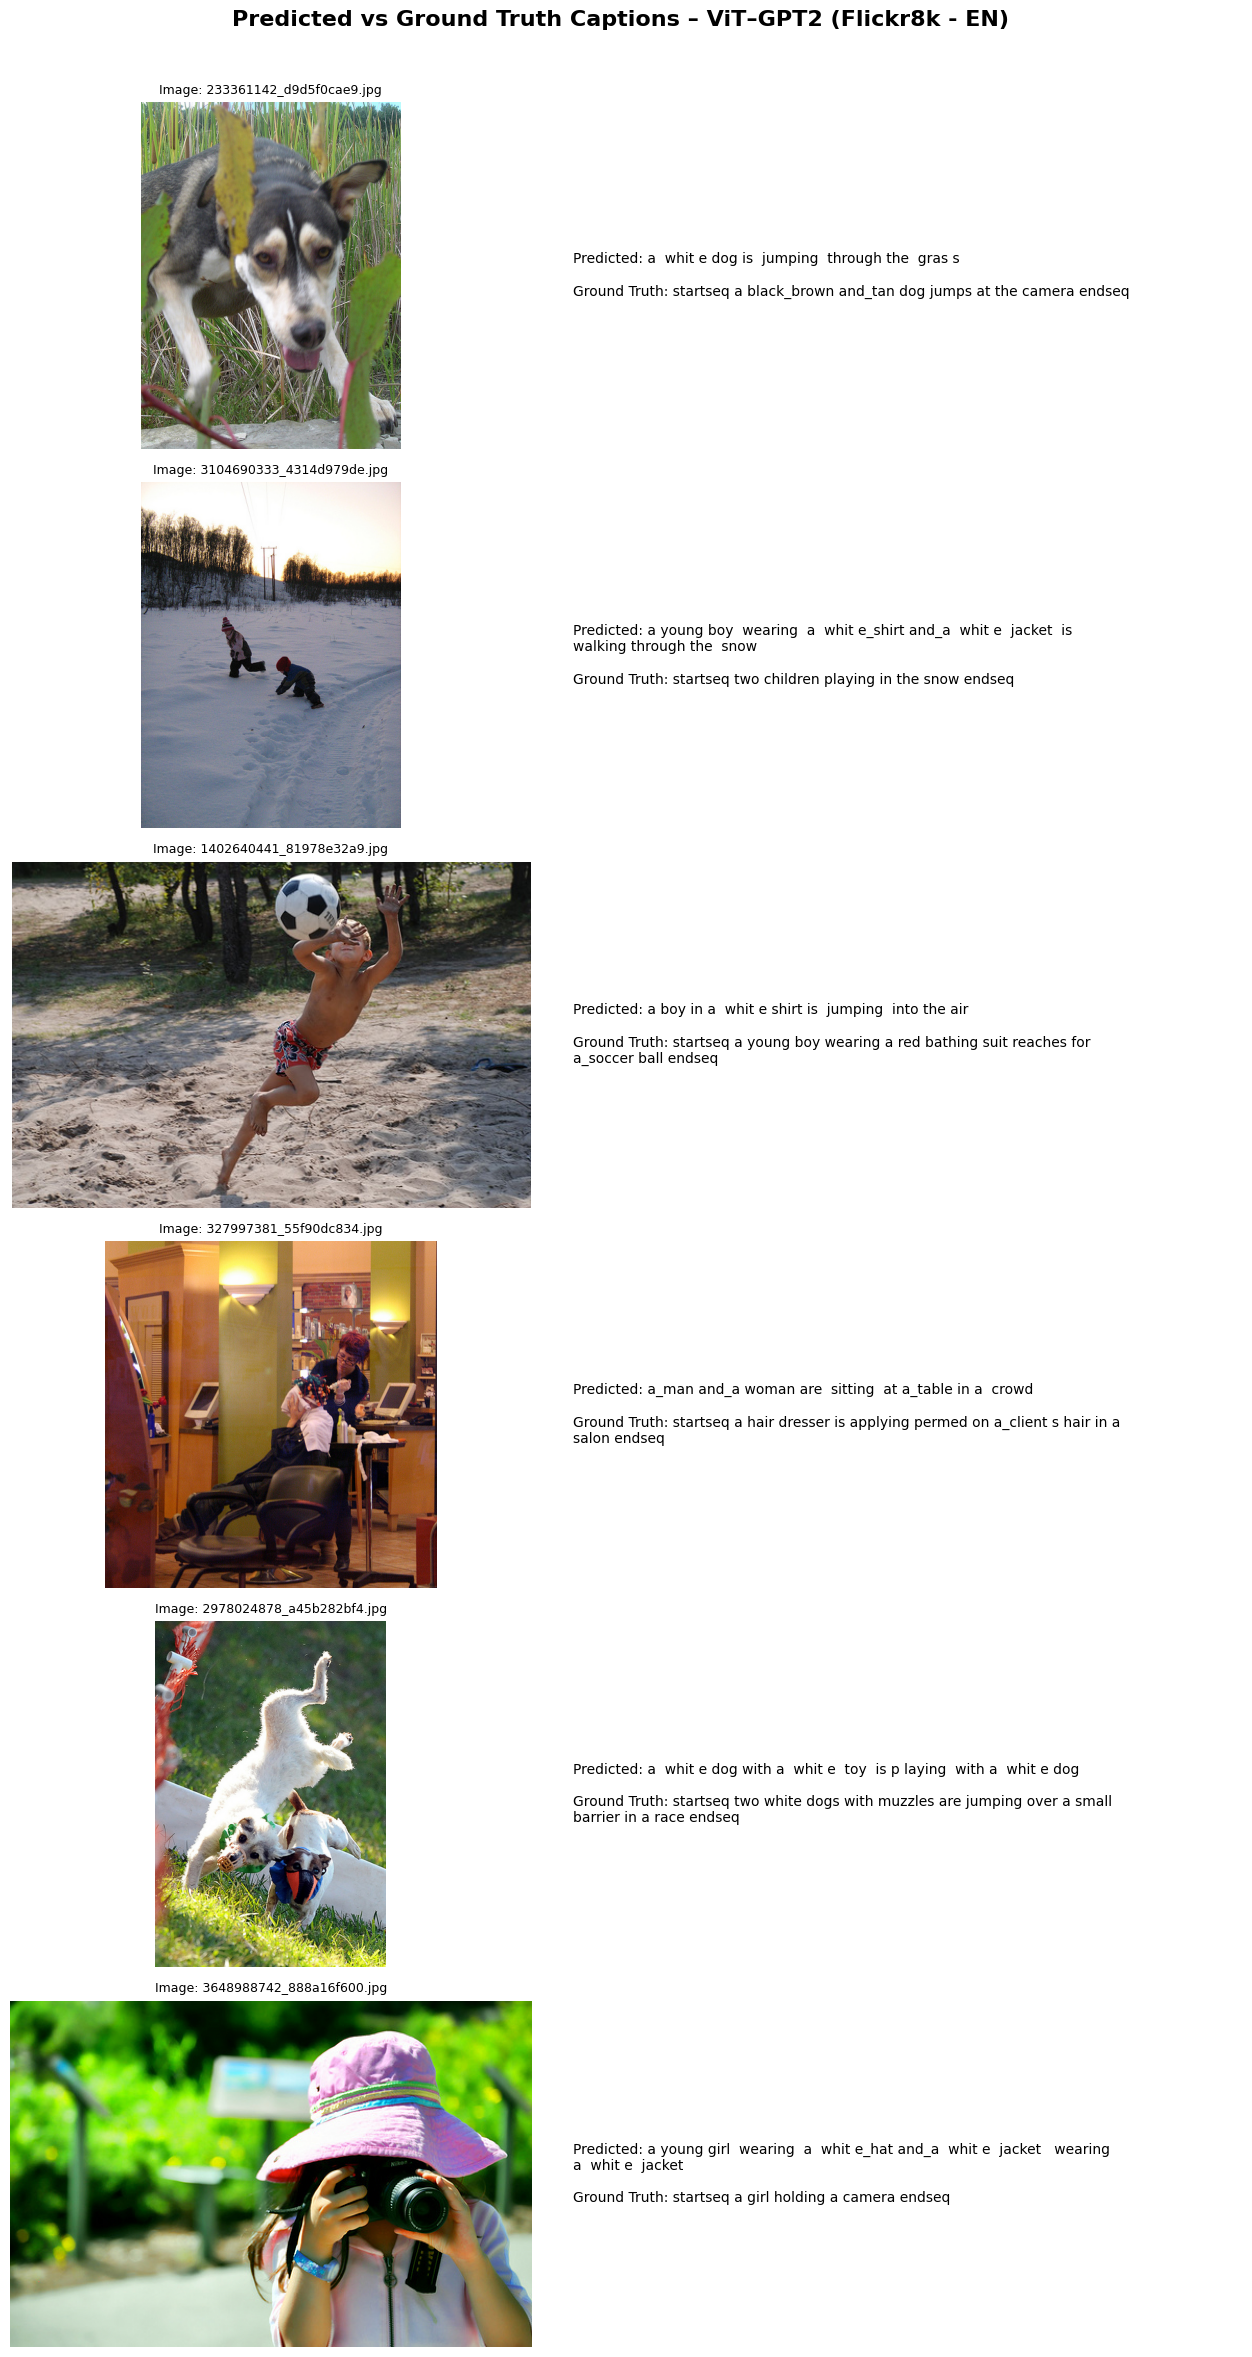

In [ ]:
import random
import textwrap
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms

sample_imgs = random.sample(list(val_df["image"].unique()), 6)
fig, axes = plt.subplots(len(sample_imgs), 2, figsize=(14, 4 * len(sample_imgs)))

tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(DATA_IMG_DIR, img_name)
    if not os.path.exists(img_path):
        continue

    # Chuẩn bị ảnh tensor
    img = Image.open(img_path).convert("RGB")
    pixel_values = tf(img).unsqueeze(0).to(DEVICE)

    # Caption dự đoán
    pred_caption = model_en.generate_caption(pixel_values, tokenizer_en, max_length=50, beam_k=3, device=DEVICE)

    if img_name in train_df["image"].values:
        gt_list = train_df[train_df["image"] == img_name]["caption"].tolist()
    else:
        gt_list = val_df[val_df["image"] == img_name]["caption"].tolist()
    gt = random.choice(gt_list)

    axes[i, 0].imshow(img)
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"Image: {img_name}", fontsize=9)
    wrapped_pred = "\n".join(textwrap.wrap(f"Predicted: {pred_caption}", 80))
    wrapped_gt = "\n".join(textwrap.wrap(f"Ground Truth: {gt}", 80))
    caption_text = f"{wrapped_pred}\n\n{wrapped_gt}"

    axes[i, 1].text(0, 0.5, caption_text, fontsize=10, va='center', ha='left', wrap=True)
    axes[i, 1].axis("off")

plt.suptitle("Predicted vs Ground Truth Captions – ViT–GPT2 (Flickr8k - EN)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
